## Requerimientos

In [2]:
!pip install geopandas
!pip install PySAL
!pip install descartes
!pip install -U -q PyDrive
!pip install unidecode

In [0]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font='Linux Biolinum O', context='poster', palette='viridis')
%config InlineBackend.figure_format='retina'
import unidecode

## Funciones Auxiliares

In [0]:
# from geopandas
def __pysal_choro(values, scheme, k=5):
    """
    Wrapper for choropleth schemes from PySAL for use with plot_dataframe
    Parameters
    ----------
    values
        Series to be plotted
    scheme : str
        One of pysal.esda.mapclassify classification schemes
        Options are 'Equal_interval', 'Quantiles', 'Fisher_Jenks'
    k : int
        number of classes (2 <= k <=9)
    Returns
    -------
    binning
        Binning objects that holds the Series with values replaced with
        class identifier and the bins.
    """
    try:
        from pysal.esda.mapclassify import (
            Quantiles, Equal_Interval, Fisher_Jenks, User_Defined)
        schemes = {}
        schemes['equal_interval'] = Equal_Interval
        schemes['quantiles'] = Quantiles
        schemes['fisher_jenks'] = Fisher_Jenks
        schemes['user_defined'] = User_Defined
        scheme = scheme.lower()
        if scheme not in schemes:
            raise ValueError("Invalid scheme. Scheme must be in the"
                             " set: %r" % schemes.keys())
        binning = schemes[scheme](values, k)
        return binning
    except ImportError:
        raise ImportError("PySAL is required to use the 'scheme' keyword")


In [0]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.patches import Polygon, Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable

def feature_to_patch(s):
    s_arr = np.array(s.exterior.xy).T
    return Polygon(s_arr, closed=False)

def colorbar(ax, collection, orientation='vertical', percent=3, **cbar_kws):
    divider = make_axes_locatable(ax)
    position = 'right' if orientation == 'vertical' else 'bottom'
    label = cbar_kws.pop('label', None)
    cax = divider.append_axes(position, size="{}%".format(percent), pad=0.05)
    cbar = plt.colorbar(collection, cax=cax, orientation=orientation, **cbar_kws)
    cbar.set_label(label)
    return cbar

def choropleth(geodf, figsize=12, column=None, scheme='fisher_jenks', 
                   user_bins=None,
                   n_colors=5, palette='viridis', alpha=0.75, cbar_orientation='vertical',
                   img_interpolation='hanning', cbar_fig_position=None, cbar_label=None, z=None, cbar_kws=None):
        
    bounds = geodf.total_bounds
    aspect = (bounds[2] - bounds[0]) / (bounds[3] - bounds[1])
    fig = plt.figure(figsize=(figsize, figsize / aspect))

    ax = plt.gca()
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_aspect(1)
    
    plt.axis('off')
    
    cbar_kws = cbar_kws if cbar_kws else {}
    
    choro = []
    patch_values = []
        
    for idx, row in geodf.iterrows():
        feature = row.geometry
        value = row[column]

        if feature.geom_type == 'Polygon':
            choro.append(feature_to_patch(feature))
            patch_values.append(value)
        elif feature.geom_type == 'MultiPolygon':
            for subfeature in feature:
                choro.append(feature_to_patch(subfeature))
                patch_values.append(value)
        else:
            continue

    binning = __pysal_choro(geodf[column], scheme=scheme, k=n_colors if scheme != 'user_defined' else user_bins)
    if scheme != 'user_defined':
        bins = np.insert(binning.bins, 0, geodf[column].min())
    else:
        bins = binning.bins

    palette_values = sns.color_palette(palette, n_colors=n_colors)
    cmap, norm = from_levels_and_colors(bins, palette_values, extend='neither')
    cmap.set_over(palette_values[-1], alpha=alpha)

    collection = PatchCollection(choro, linewidth=1, edgecolor='white', alpha=alpha, cmap=cmap, norm=norm)    
    collection.set_array(np.array(patch_values))

    cbar_label = cbar_label if cbar_label is not None else column
    
    cbar_kws = dict(label=cbar_label, ticks=bins)
    #{'label': 'Inmigrantes por comuna año 2006', 'ticks': array([   93,   728,  1791,  3017,  5248, 10954])}
    colorbar(ax, collection, orientation=cbar_orientation, **cbar_kws)        
        
    ax.add_collection(collection)
    plt.tight_layout()
    return ax

## Cargar datos desde Google drive


In [6]:

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'0B5OgEYX8Qy2mRFI3YW1mQlZmQVE' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


!mv /content/data/asdf.zip /content
!ls

title: asdf.zip, id: 1SIOk_f3zCiEcaVsZTQWciyzMMTZQslmo
downloading to /content/data/asdf.zip
adc.json			migrants_2008.png  R13
asdf.zip			migrants_2009.png  retired.png
Censo2017_Manzanas.csv		migrants_2010.png  sample_data
data				migrants_2011.png  shapefile_comunas
dataComunaFormatted.csv		migrants_2012.png  urban_areas
datalab				migrants_2013.png  urban_districts.json
Microdato_Censo2017-Urbano.csv	migrants_2014.png  visas.csv
migrants_2005.png		migrants_2015.png  women_to_men_ratio.png
migrants_2006.png		migrants_2016.png
migrants_2007.png		migrants.png


In [7]:
!unzip asdf.zip

Archive:  asdf.zip
replace R13/Distritos_Censales.shp.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Limipiar Datos

In [8]:
visas = pd.read_csv('visas.csv',sep=';')
visas['Comuna Id'] = visas['Comuna Datachile Id']
visas = visas.drop(columns=['Comuna Datachile Id','Activity Id (Activity Id.Csv)','Studies Id (Studies Id.Csv)','Visa Type Id (Visa Type.Csv)','Sub Region Code','Sub Region','Visa Type Id','Sex Id (Sex Id.Csv)','Sex Id'])
visas.head()

% del Trabajo  Número de registros    Activity  Activity Id  Age  \
0              1                    1    Empleado            2   21   
1              1                    1    Empleado            2   35   
2              1                    1    Empleado            2   22   
3              1                    1  Estudiante            5   21   
4              1                    1  Estudiante            5   30   

  Birth Date  Country Code Country Name Es Country Name Iso3    Region  \
0  17/1/1984           219         Peru            Perú  PER  Americas   
1  11/7/1970           221      Bolivia         Bolivia  BOL  Americas   
2  18/1/1983           218      Ecuador         Ecuador  ECU  Americas   
3  15/3/1984           128      Morocco       Marruecos  MAR    Africa   
4   7/8/1975           336        China           China  CHN      Asia   

   Region Code  Region Id        Sex                  Studies  Studies Id  \
0           19         13   Femenino                      NaN           0   
1           19         13   Femenino  Educación Universitaria           5   
2           19         13  Masculino                      NaN           0   
3            2         13  Masculino                      NaN           0   
4          142          9   Femenino                      NaN           0   

    Visa Type  Year  Comuna Id  
0  Estudiante  2005        290  
1  Estudiante  2005        228  
2  Estudiante  2005        228  
3  Estudiante  2005        134  
4  Estudiante  2005        314

In [9]:

comunas = pd.read_csv('dataComunaFormatted.csv', sep=';')
comunas['DESC_COMUN'] = comunas['Comuna Name']
comunas = comunas.drop(columns='Comuna Name')
comunas['DESC_COMUN'] = comunas['DESC_COMUN'].str.upper()
# Problemas con Ñ
comunas['DESC_COMUN'] = comunas['DESC_COMUN'].apply(lambda x :  x.replace('Ã‘','N'))
comunas['DESC_COMUN'] = comunas['DESC_COMUN'].apply(lambda x :  unidecode.unidecode(x))
comunas.head()

Comuna Id       DESC_COMUN
0          1        ALGARROBO
1          2            ALHUE
2          3     ALTO BIO BIO
3          4  ALTO DEL CARMEN
4          5    ALTO HOSPICIO

#### Merge datos y filtrado por region metropolitana

In [10]:
md = visas.merge(comunas).sort_values(by=['Comuna Id'])
md = md[md['Region Id'] == 13]
md.head()

% del Trabajo  Número de registros            Activity  Activity Id  \
1480787              1                    1  Obrero o Jornalero            9   
1480786              1                    1            Inactivo            6   
1480785              1                    1          No Informa            8   
1480784              1                    1            Empleado            2   
1480803              1                    1            Empleado            2   

         Age  Birth Date  Country Code Country Name Es Country Name Iso3  \
1480787   34  14/11/1981           221      Bolivia         Bolivia  BOL   
1480786   53    1/1/1964           221      Bolivia         Bolivia  BOL   
1480785   29  14/11/1987           221      Bolivia         Bolivia  BOL   
1480784   21   8/11/1995           219         Peru            Perú  PER   
1480803   22   25/6/1994           219         Peru            Perú  PER   

           Region  Region Code  Region Id        Sex           Studies  \
1480787  Americas           19         13  Masculino  Educación Básica   
1480786  Americas           19         13  Masculino  Educación Básica   
1480785  Americas           19         13  Masculino   Educación Media   
1480784  Americas           19         13  Masculino   Educación Media   
1480803  Americas           19         13   Femenino   Educación Media   

         Studies Id   Visa Type  Year  Comuna Id DESC_COMUN  
1480787           1  Temporaria  2015          2      ALHUE  
1480786           1  Temporaria  2016          2      ALHUE  
1480785           2  Temporaria  2016          2      ALHUE  
1480784           2  Temporaria  2016          2      ALHUE  
1480803           2  Temporaria  2016          2      ALHUE

#### Contar personas por comuna

In [11]:
# poblacion_comunas_by_year = []
# years = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
# for year in years:
#   poblacion_comunas_by_year.append(md.groupby(['Comuna Id','DESC_COMUN']).size().reset_index(name='counts'))
poblacion_comuna = md.groupby(['Comuna Id','DESC_COMUN','Year']).size().reset_index(name='counts')
poblacion_comuna.head()

Comuna Id DESC_COMUN  Year  counts
0          2      ALHUE  2008       3
1          2      ALHUE  2009       5
2          2      ALHUE  2010       6
3          2      ALHUE  2011       5
4          2      ALHUE  2012      27

## Cargar mapas

#### Mapa area urbana santiago

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Linux Biolinum O'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


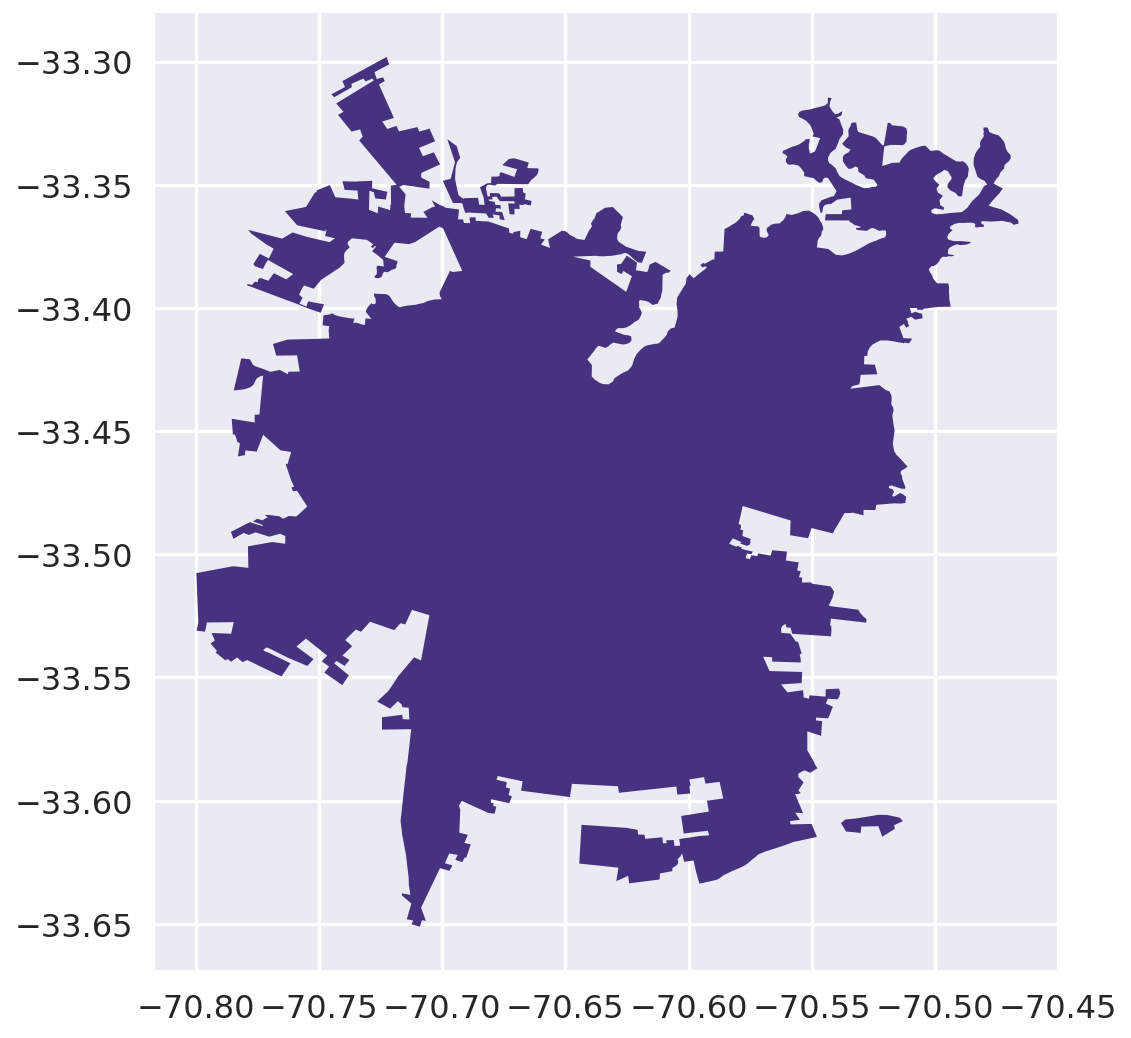

In [12]:
urban_stgo = (gpd.read_file('urban_areas/', crs={'init': 'epsg:5361'})
               .to_crs({'init': 'epsg:4326'})
               .pipe(lambda x: x[x.NOMBRE == 'Santiago'].copy()))
    
urban_stgo.plot()

#### Areas sensales santiago

In [0]:
orig = (gpd.read_file('R13/').assign(REGION=lambda x: x.REGION.astype(np.int))
         .assign(PROVINCIA=lambda x: x.PROVINCIA.astype(np.int))
         .assign(COMUNA=lambda x: x.COMUNA.astype(np.int))
         .assign(COD_DISTRI=lambda x: x.COD_DISTRI.astype(np.int)))

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Linux Biolinum O'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


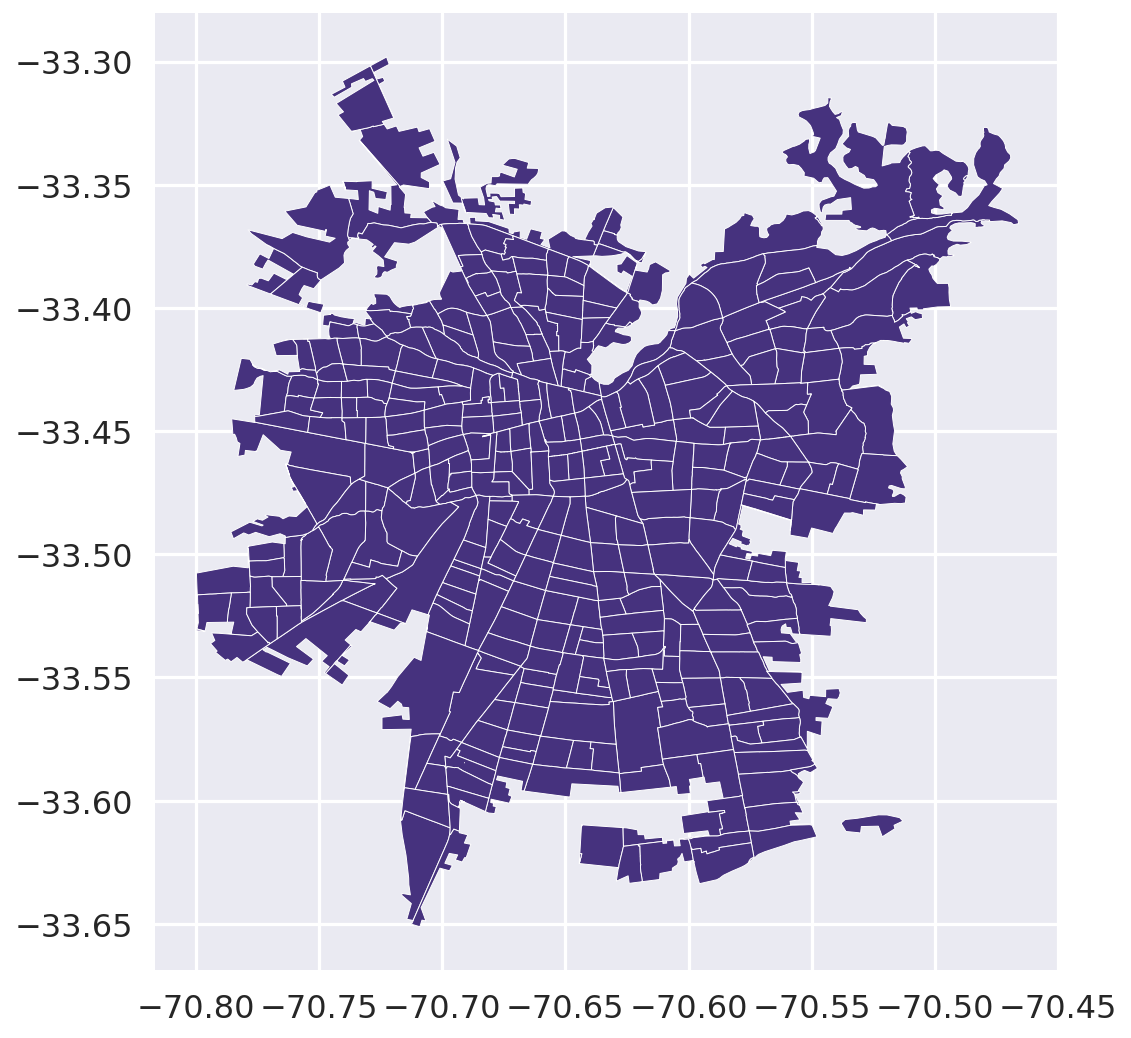

In [14]:
urban_districts = (orig
         .pipe(lambda x: x.assign(geometry=x.geometry.map(lambda y: urban_stgo.loc[385].geometry.intersection(y))))
         .pipe(lambda x: x[(x.area > 0)].copy()))
urban_districts.plot(edgecolor='white')

#### Merge areas sensales por comuna

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Linux Biolinum O'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


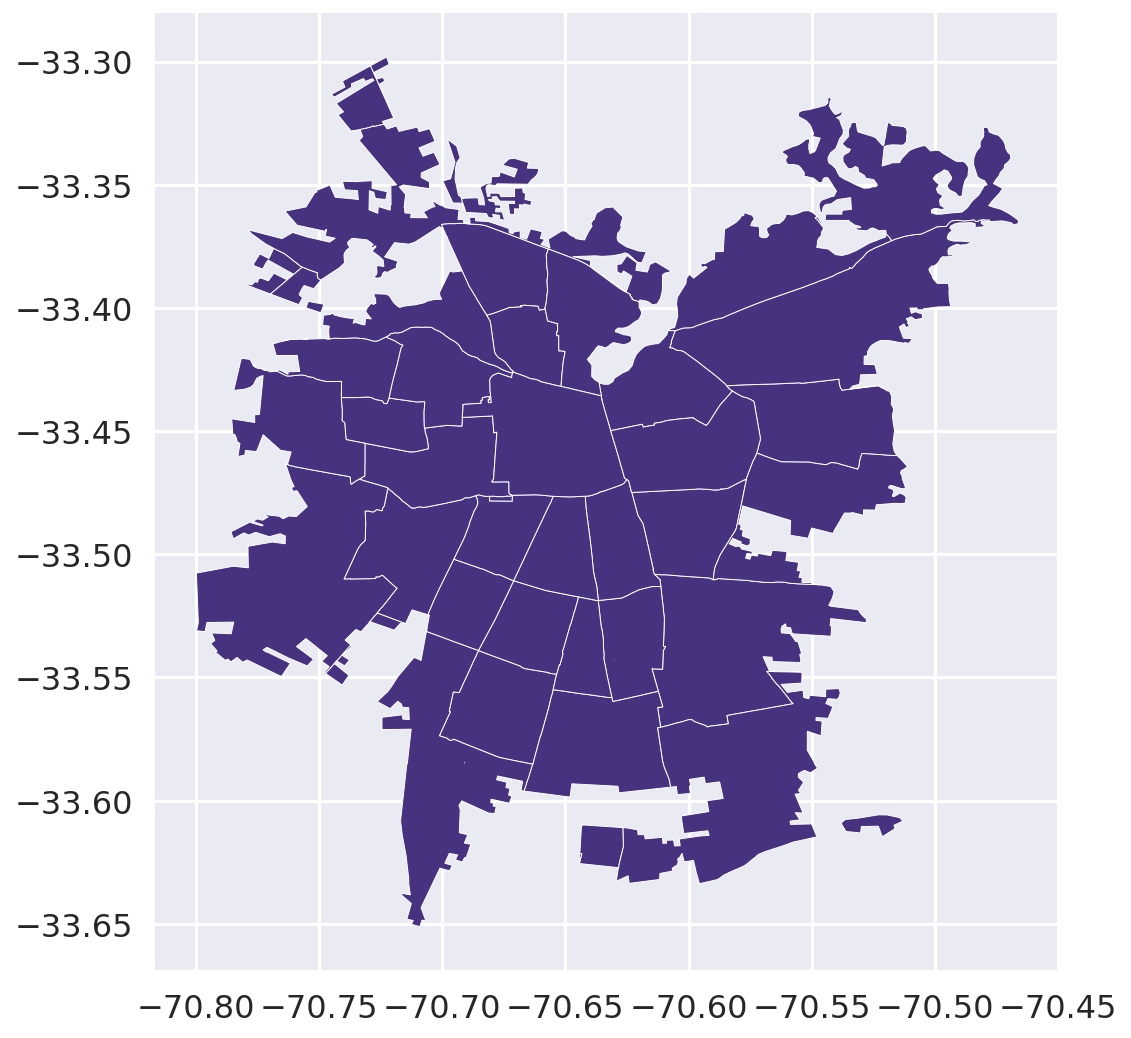

In [15]:
comunas_santiago =  urban_districts[['DESC_COMUN','geometry']]
comunas_santiago = comunas_santiago.dissolve(by='DESC_COMUN')
comunas_santiago = comunas_santiago.reset_index()
# Problemas con Ñ
comunas_santiago['DESC_COMUN'] = comunas_santiago['DESC_COMUN'].apply(lambda x :  x.replace('Ã‘','N'))
comunas_santiago['DESC_COMUN'] = comunas_santiago['DESC_COMUN'].apply(lambda x :  unidecode.unidecode(x))
comunas_santiago.plot(edgecolor='white')

## Ingresar datos al mapa

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Linux Biolinum O'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


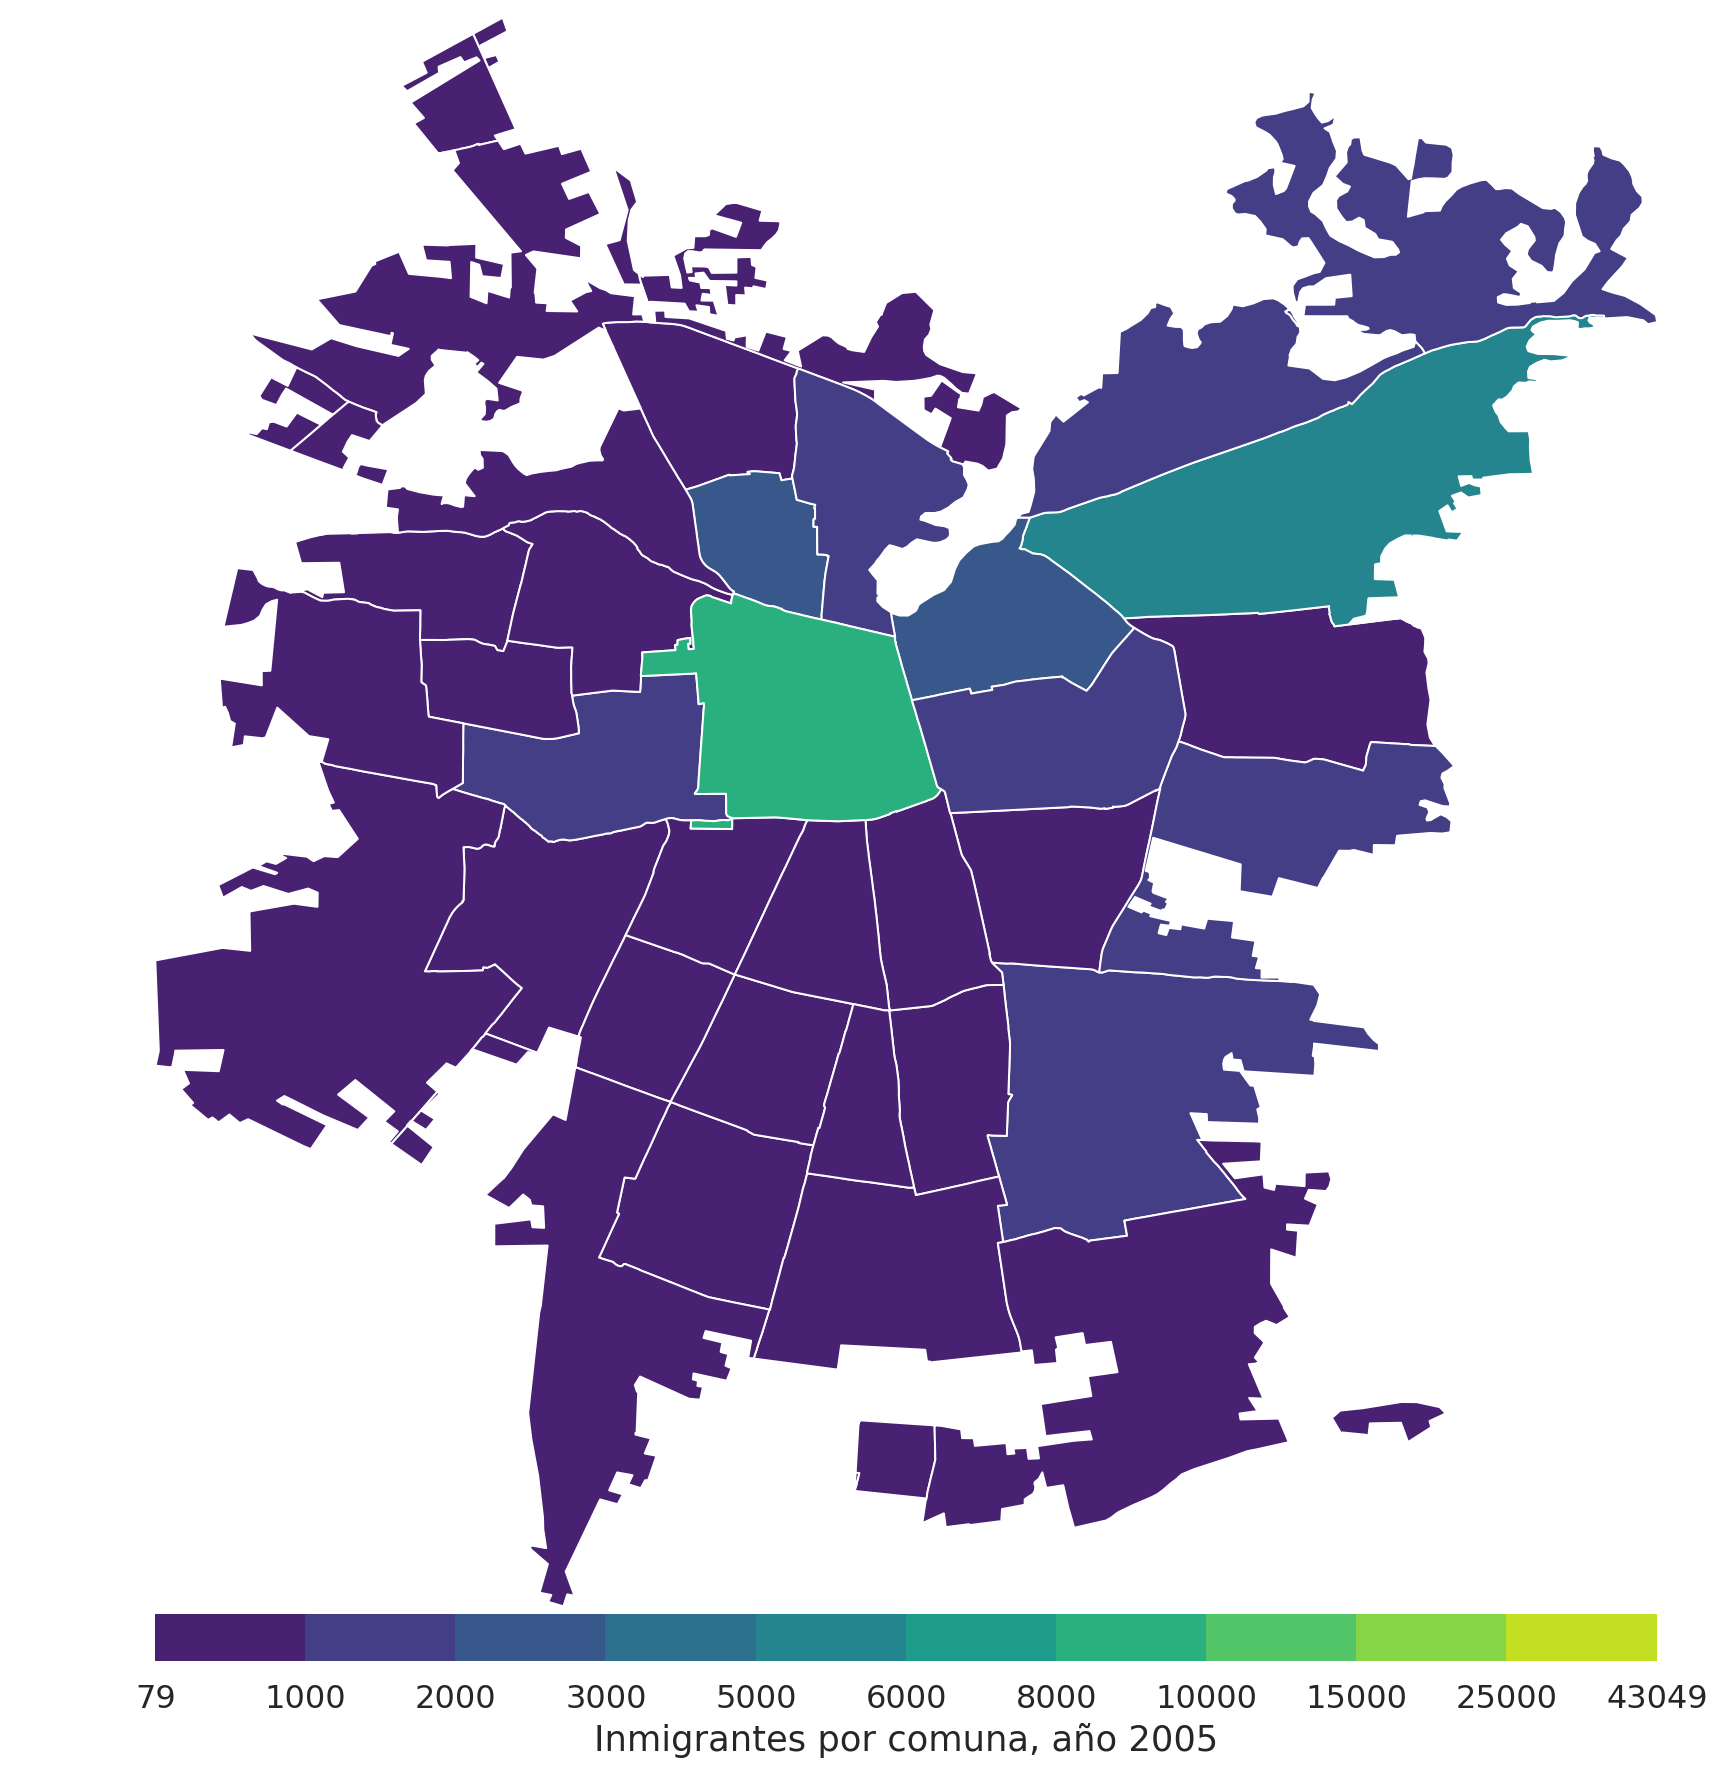

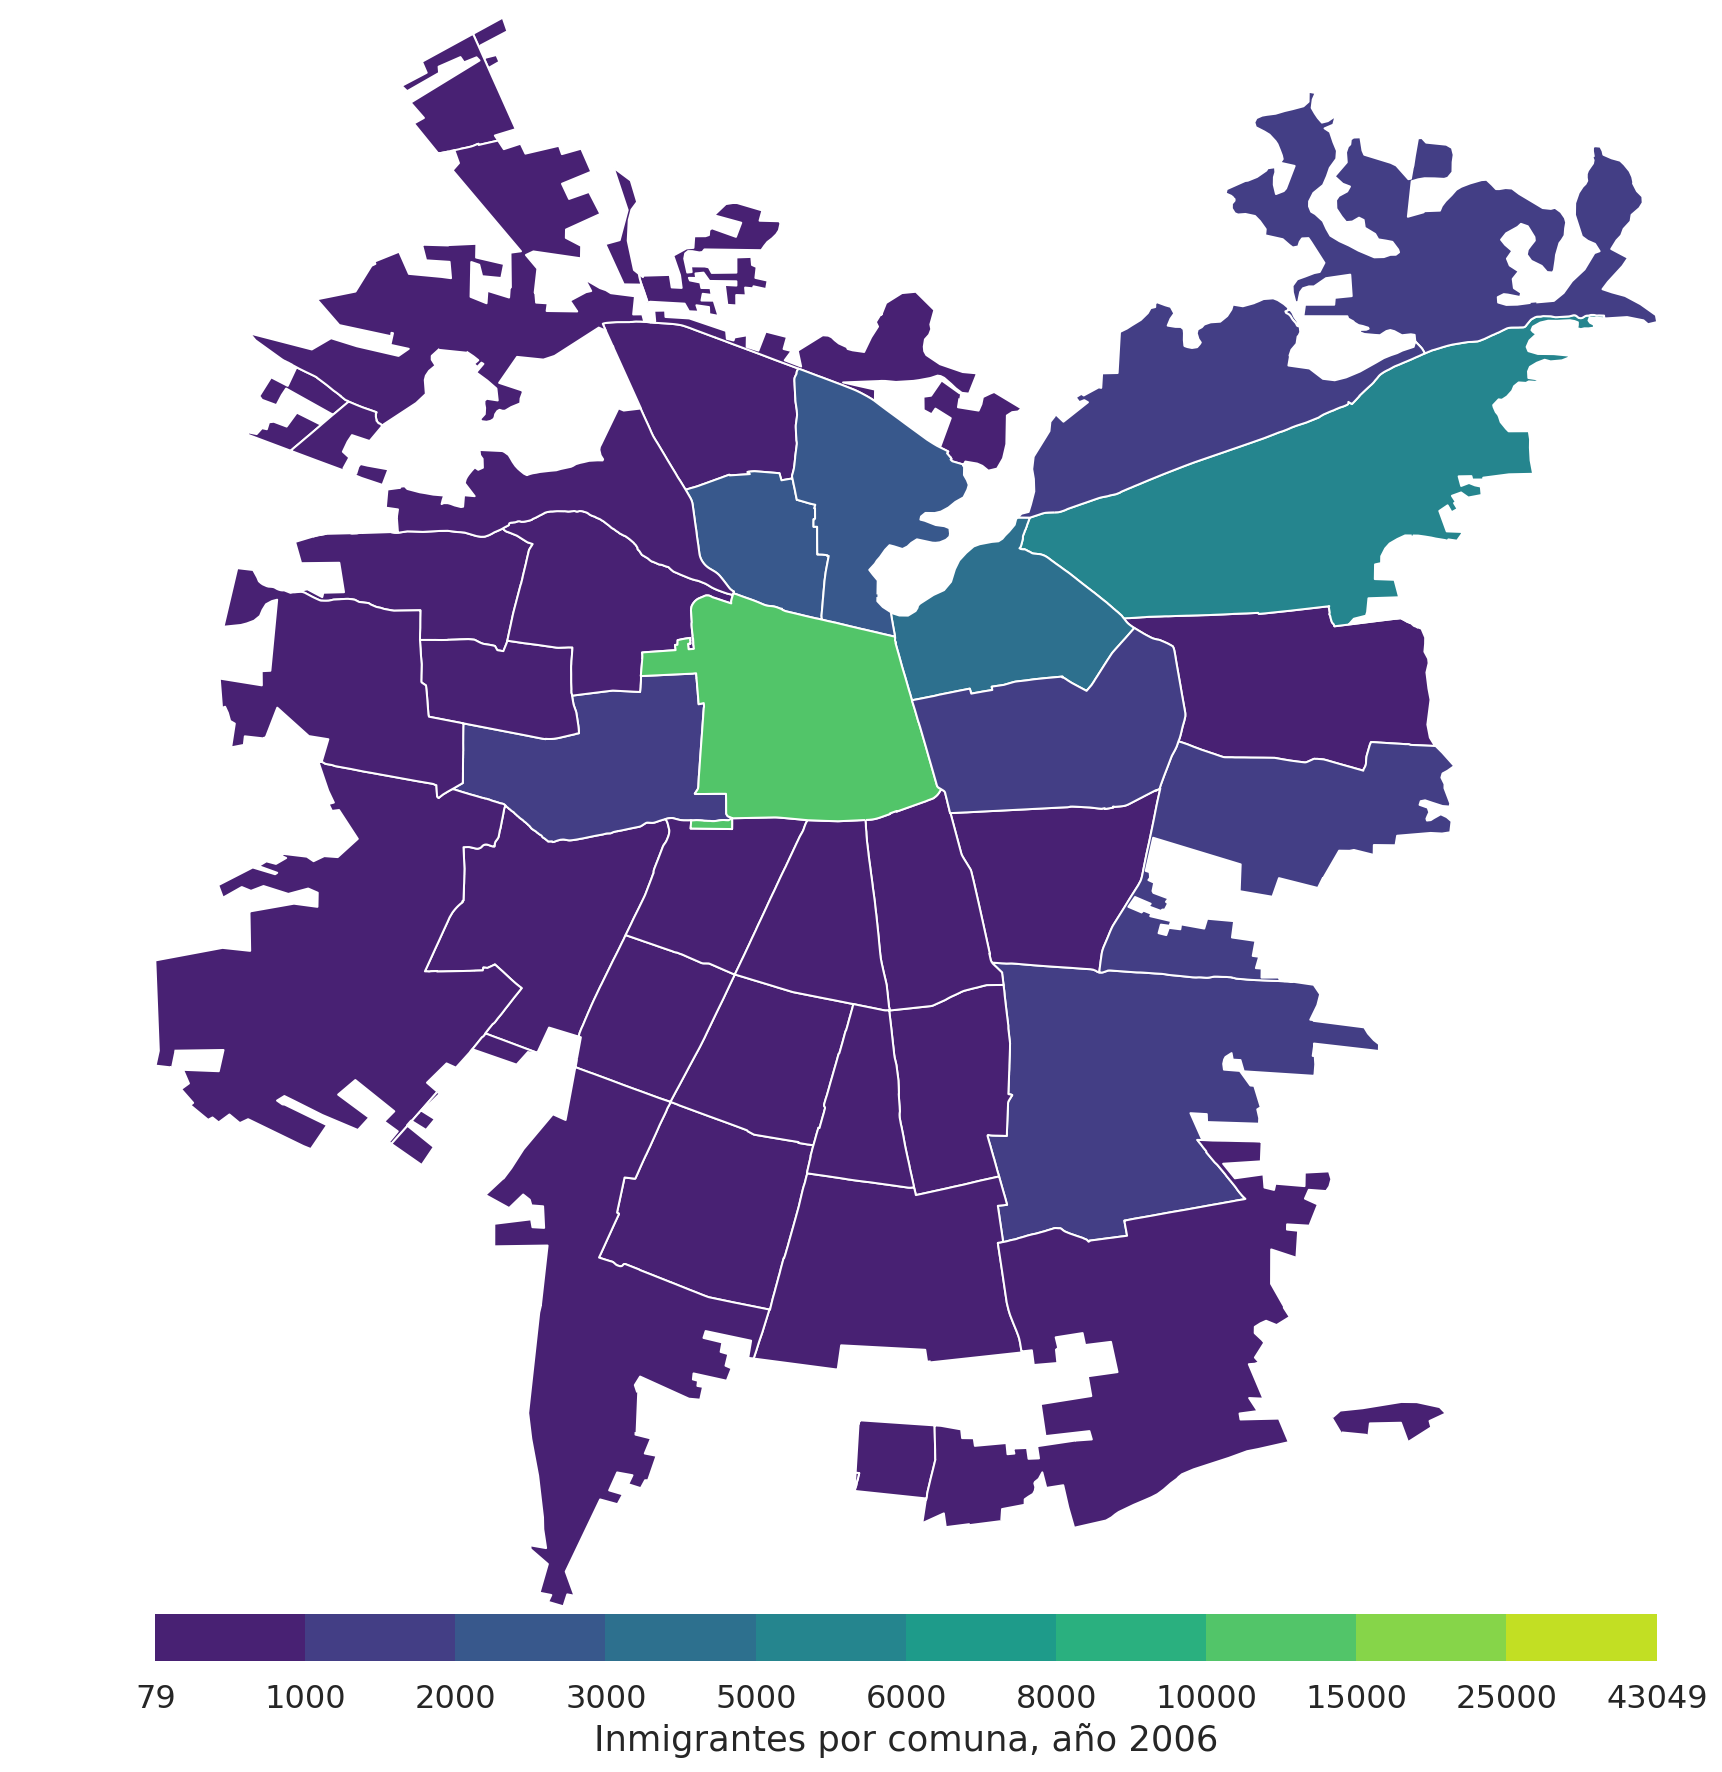

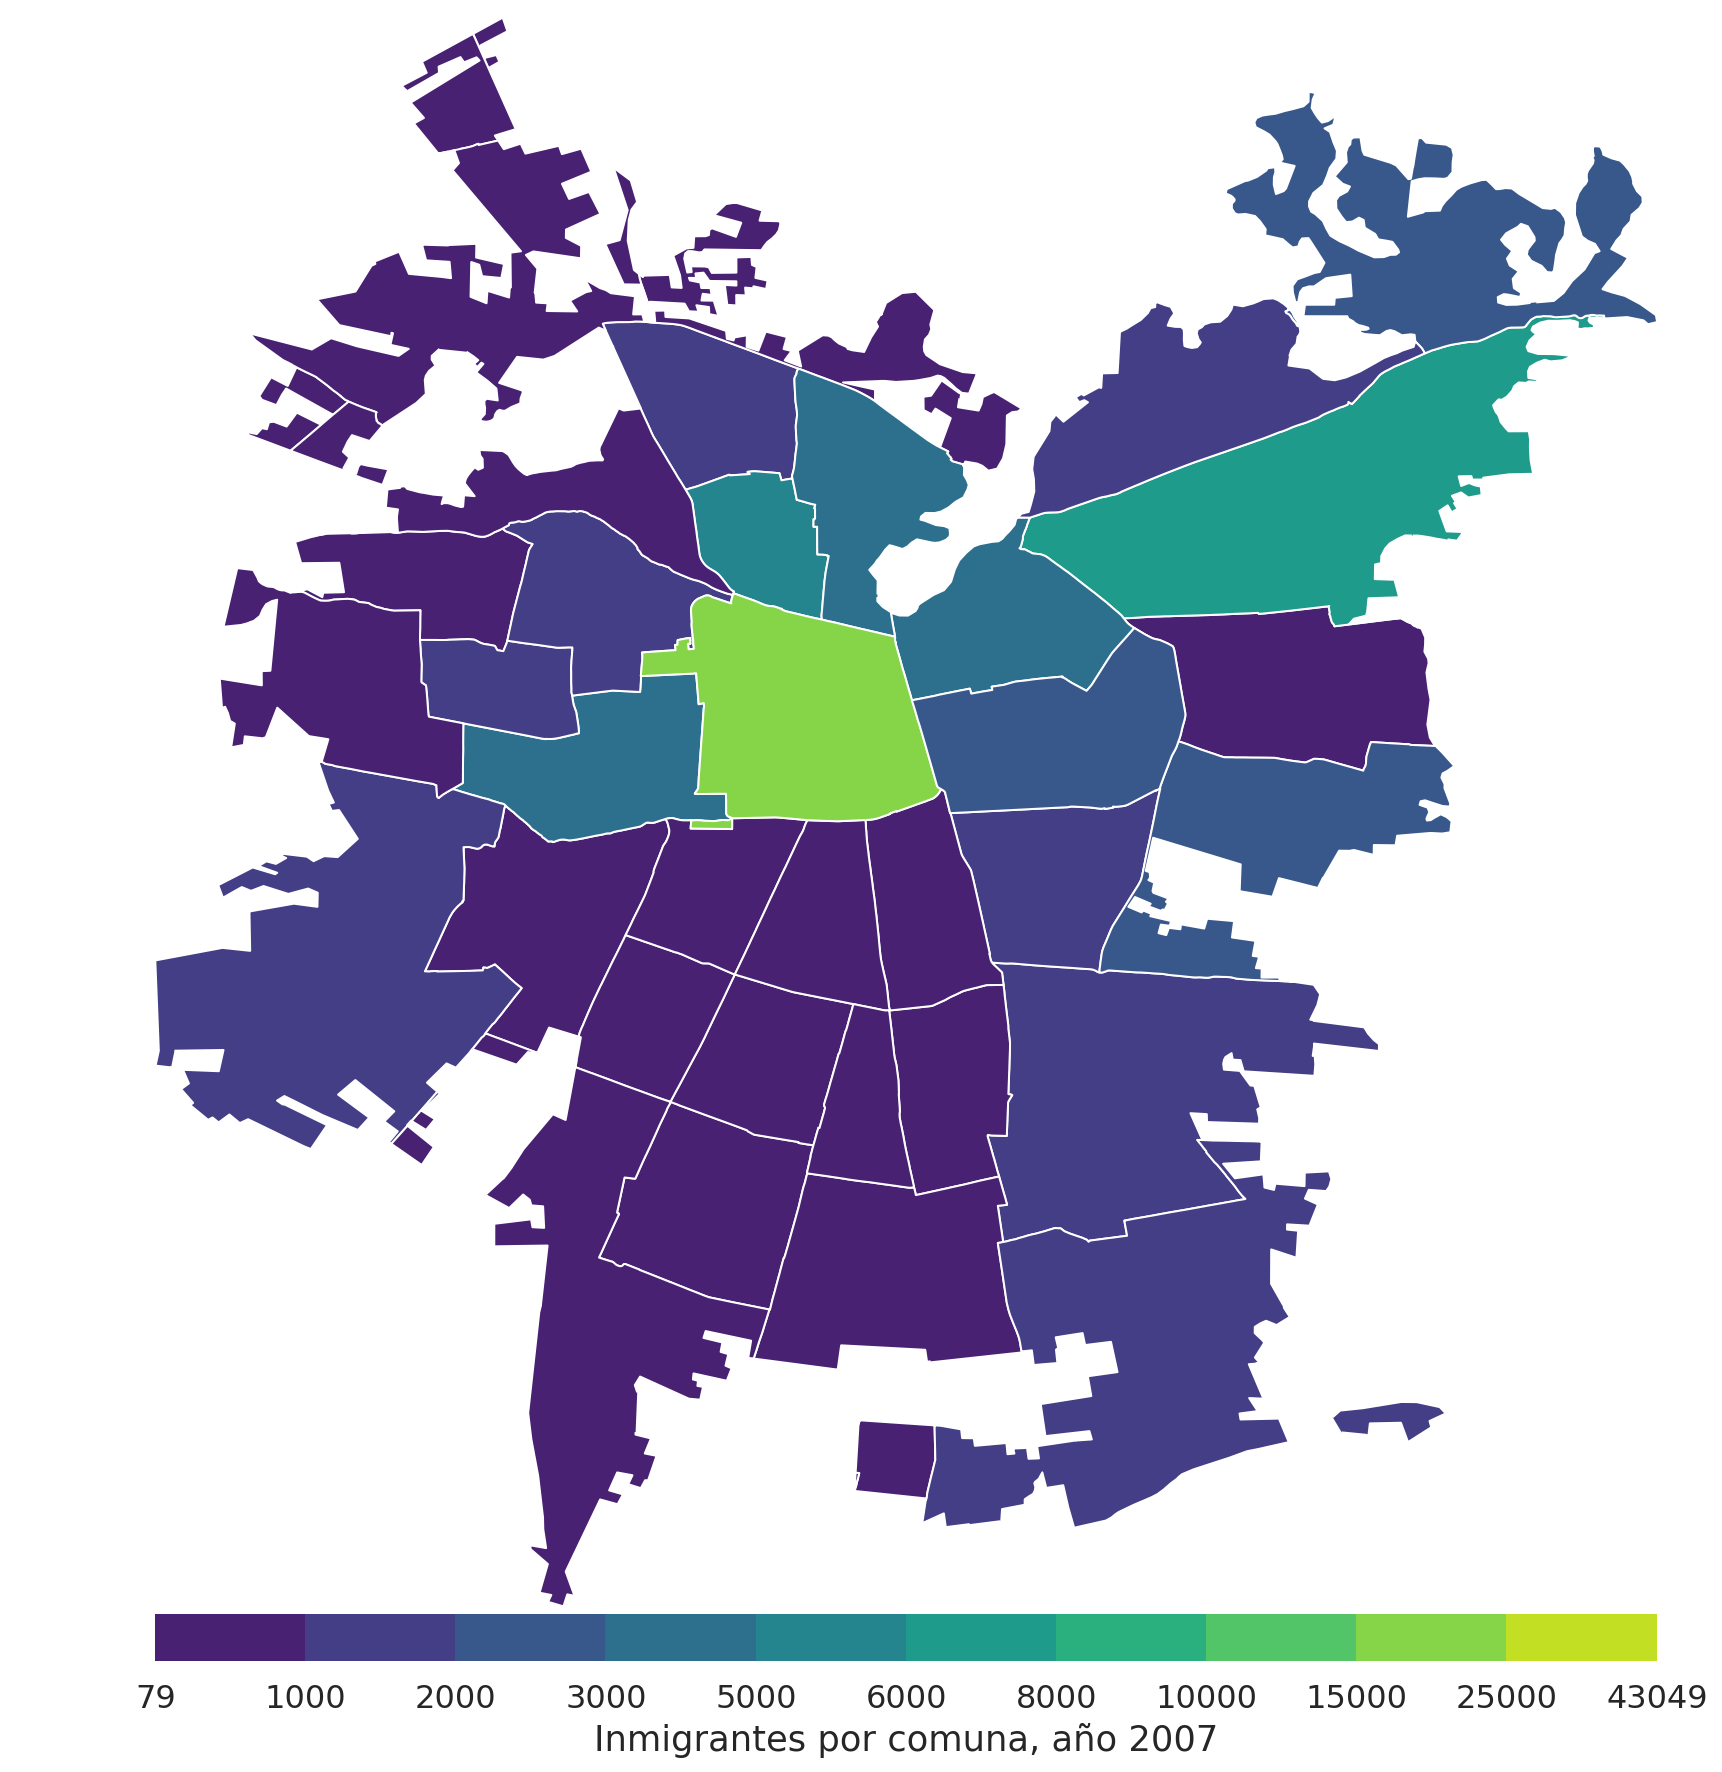

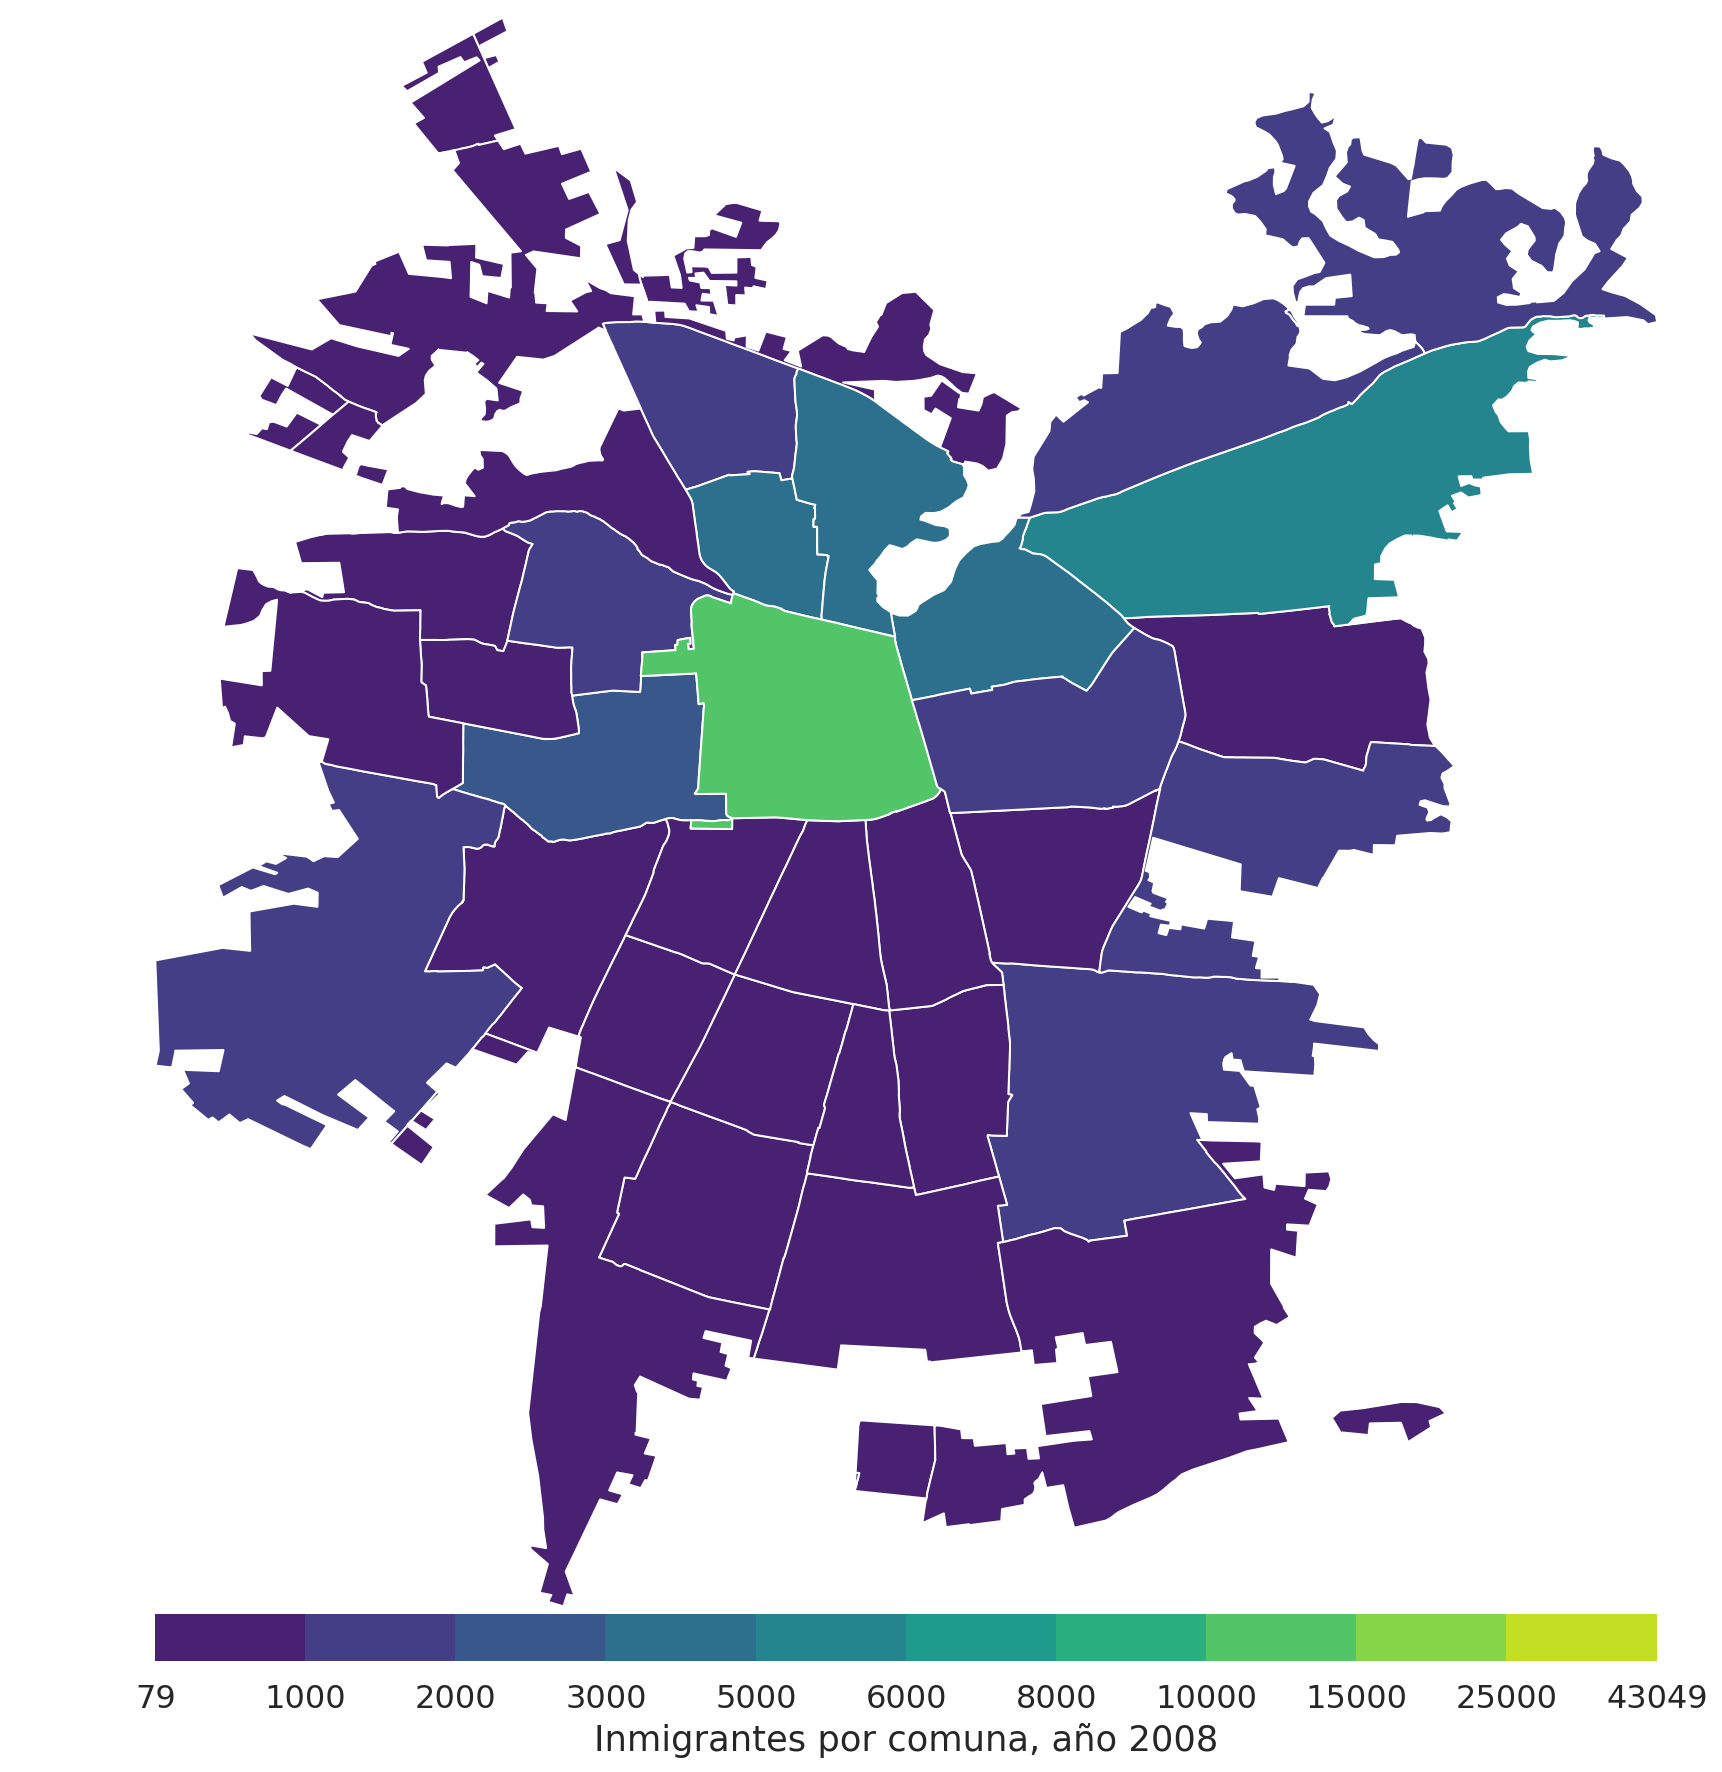

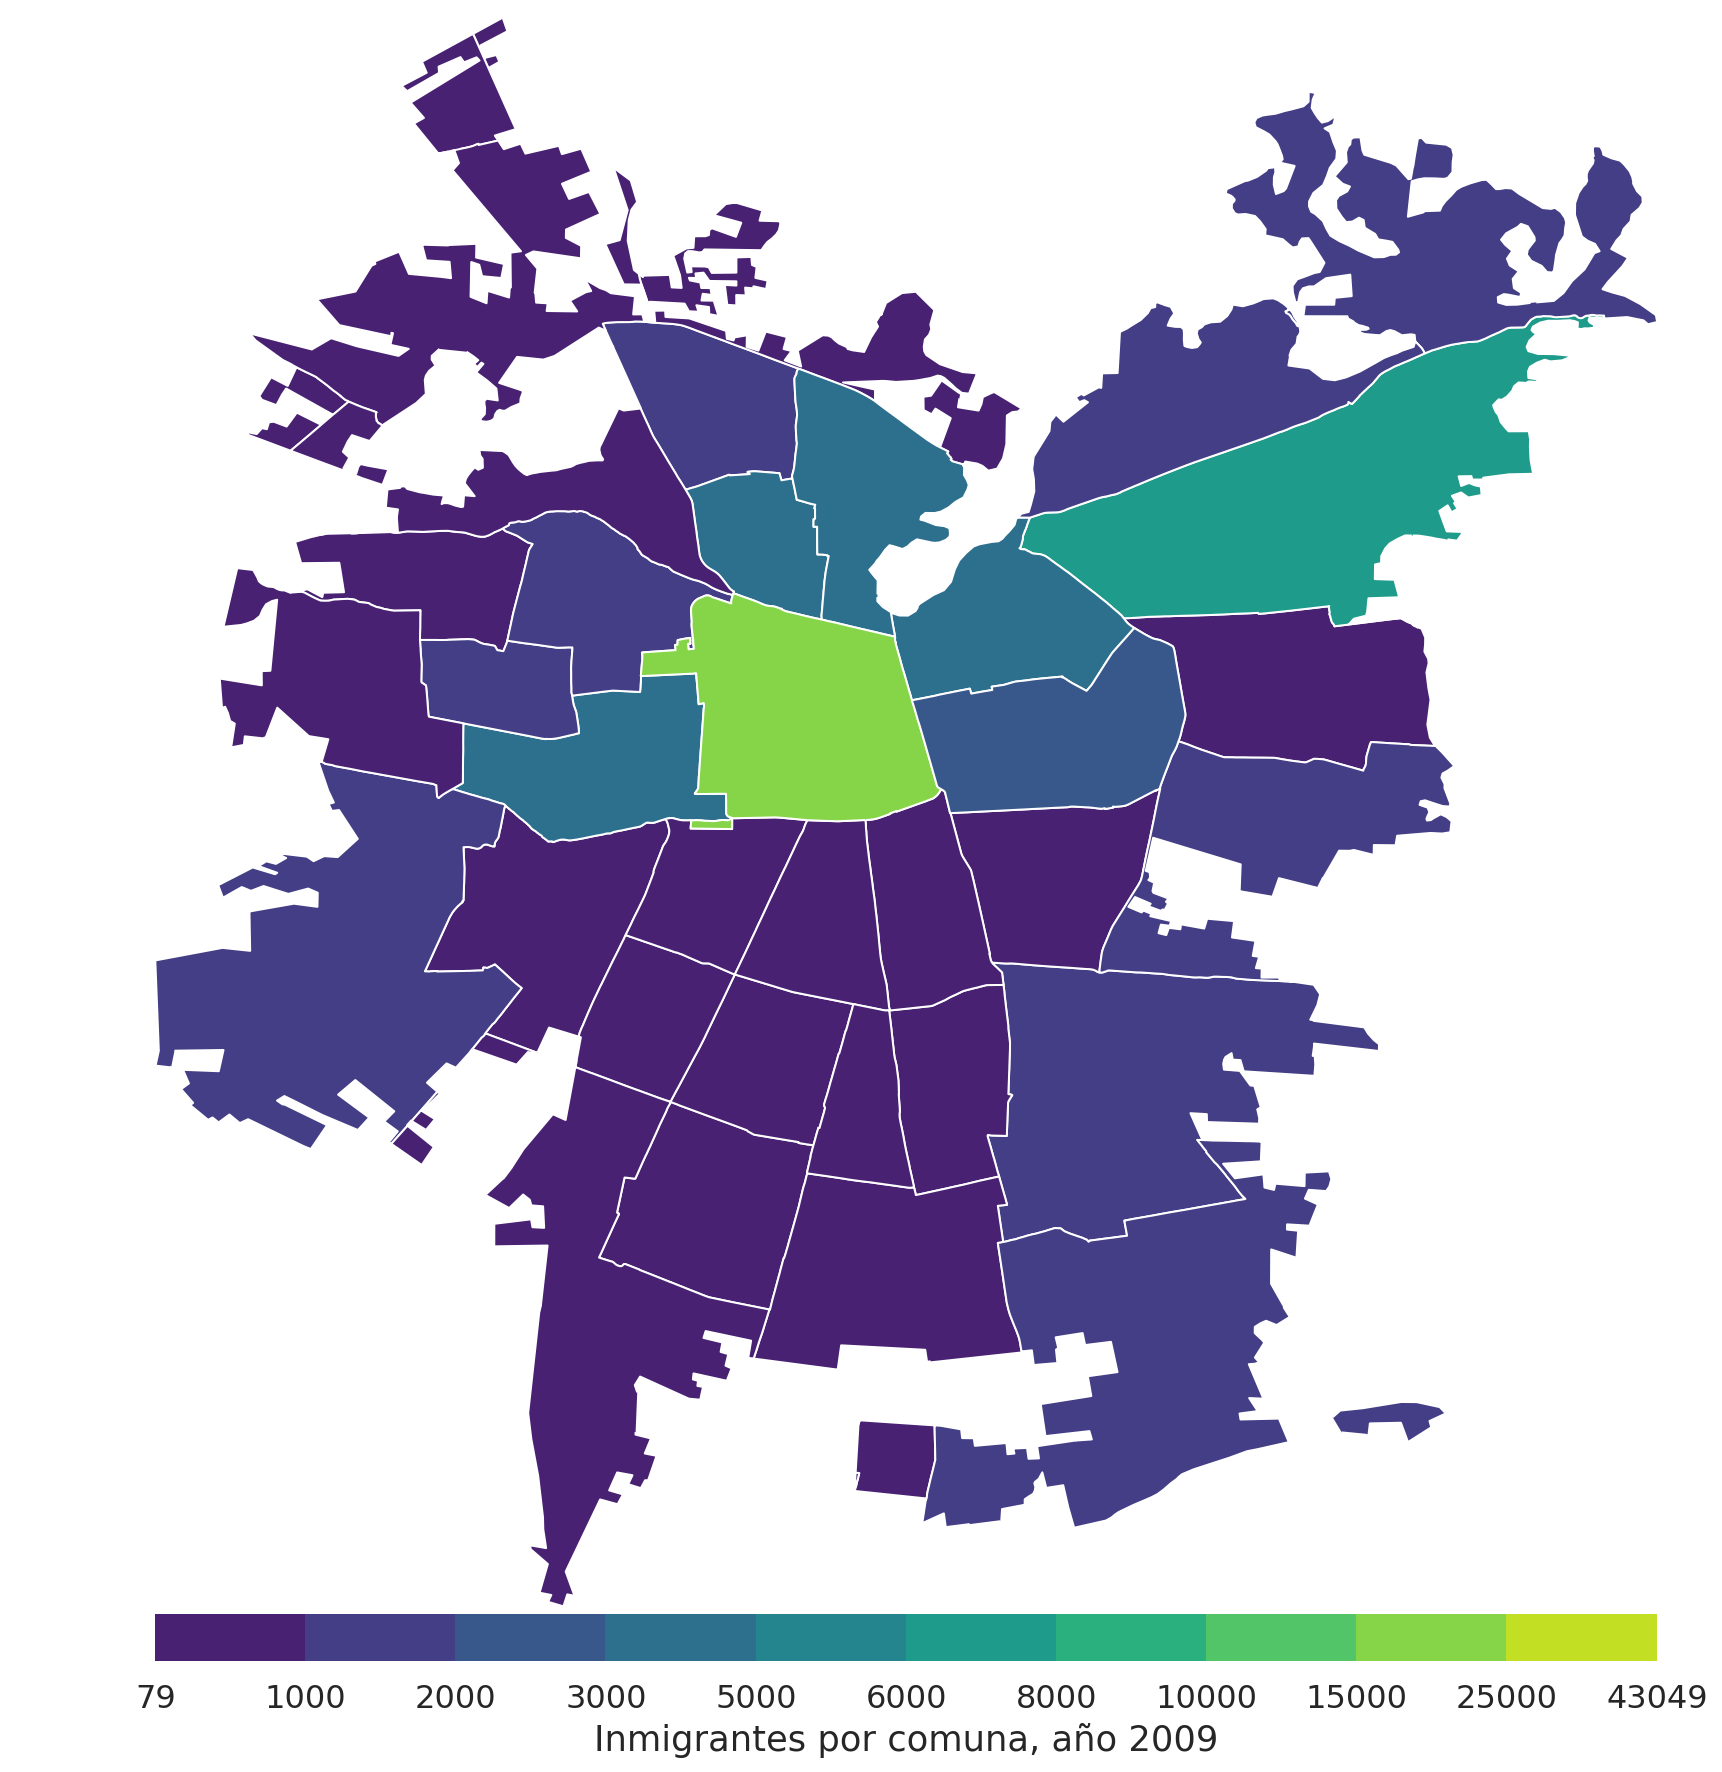

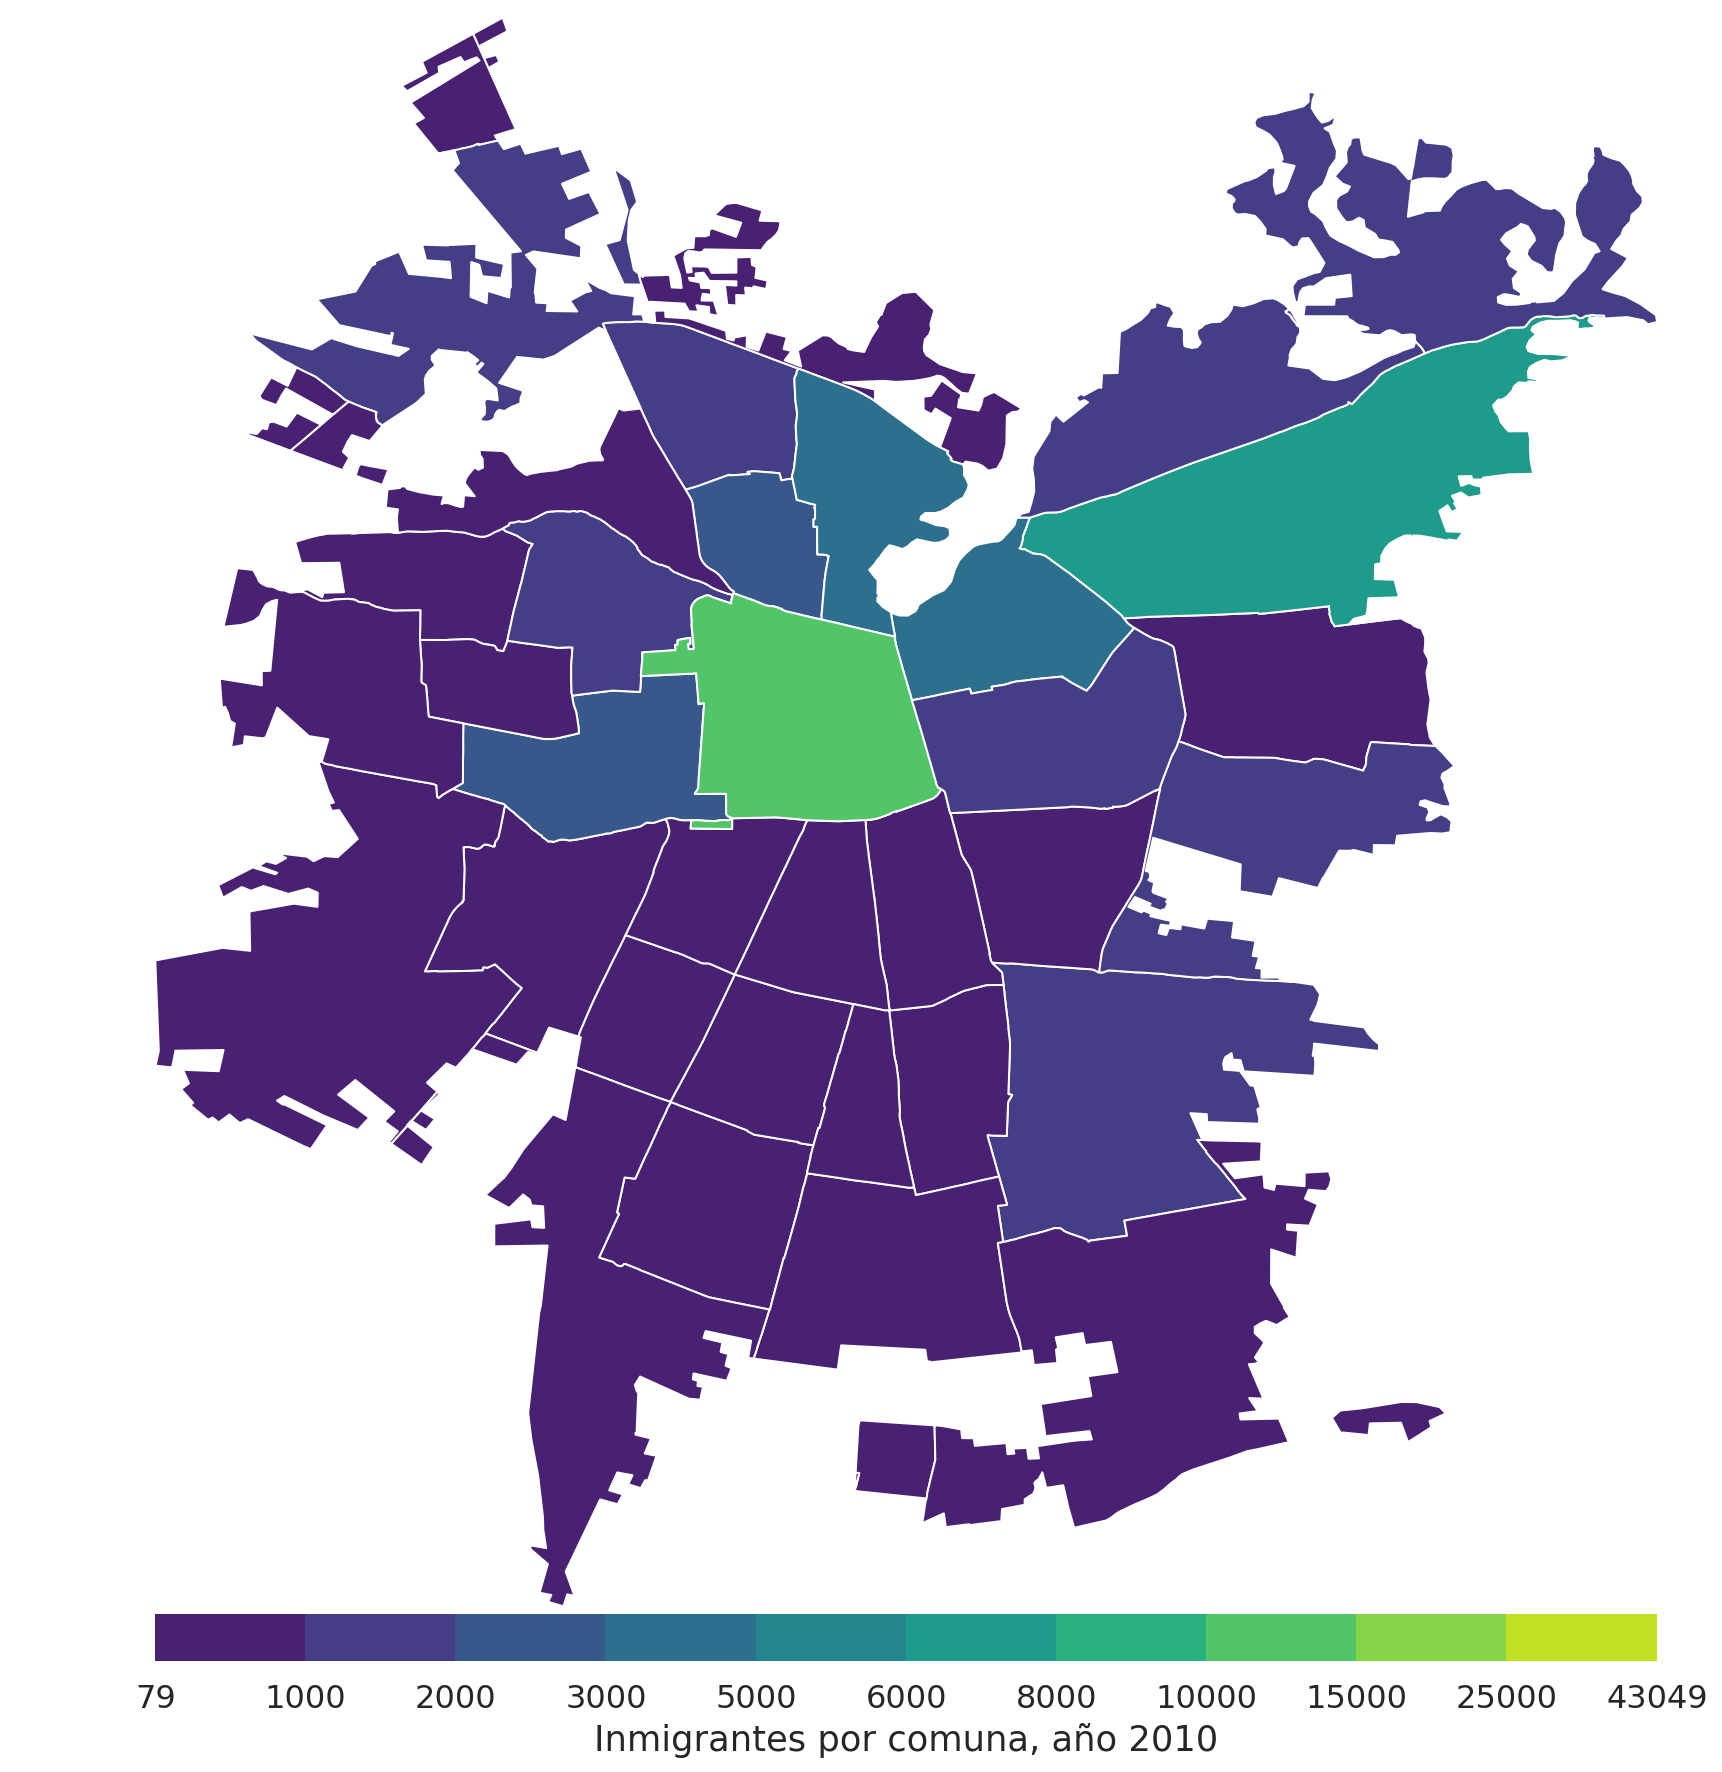

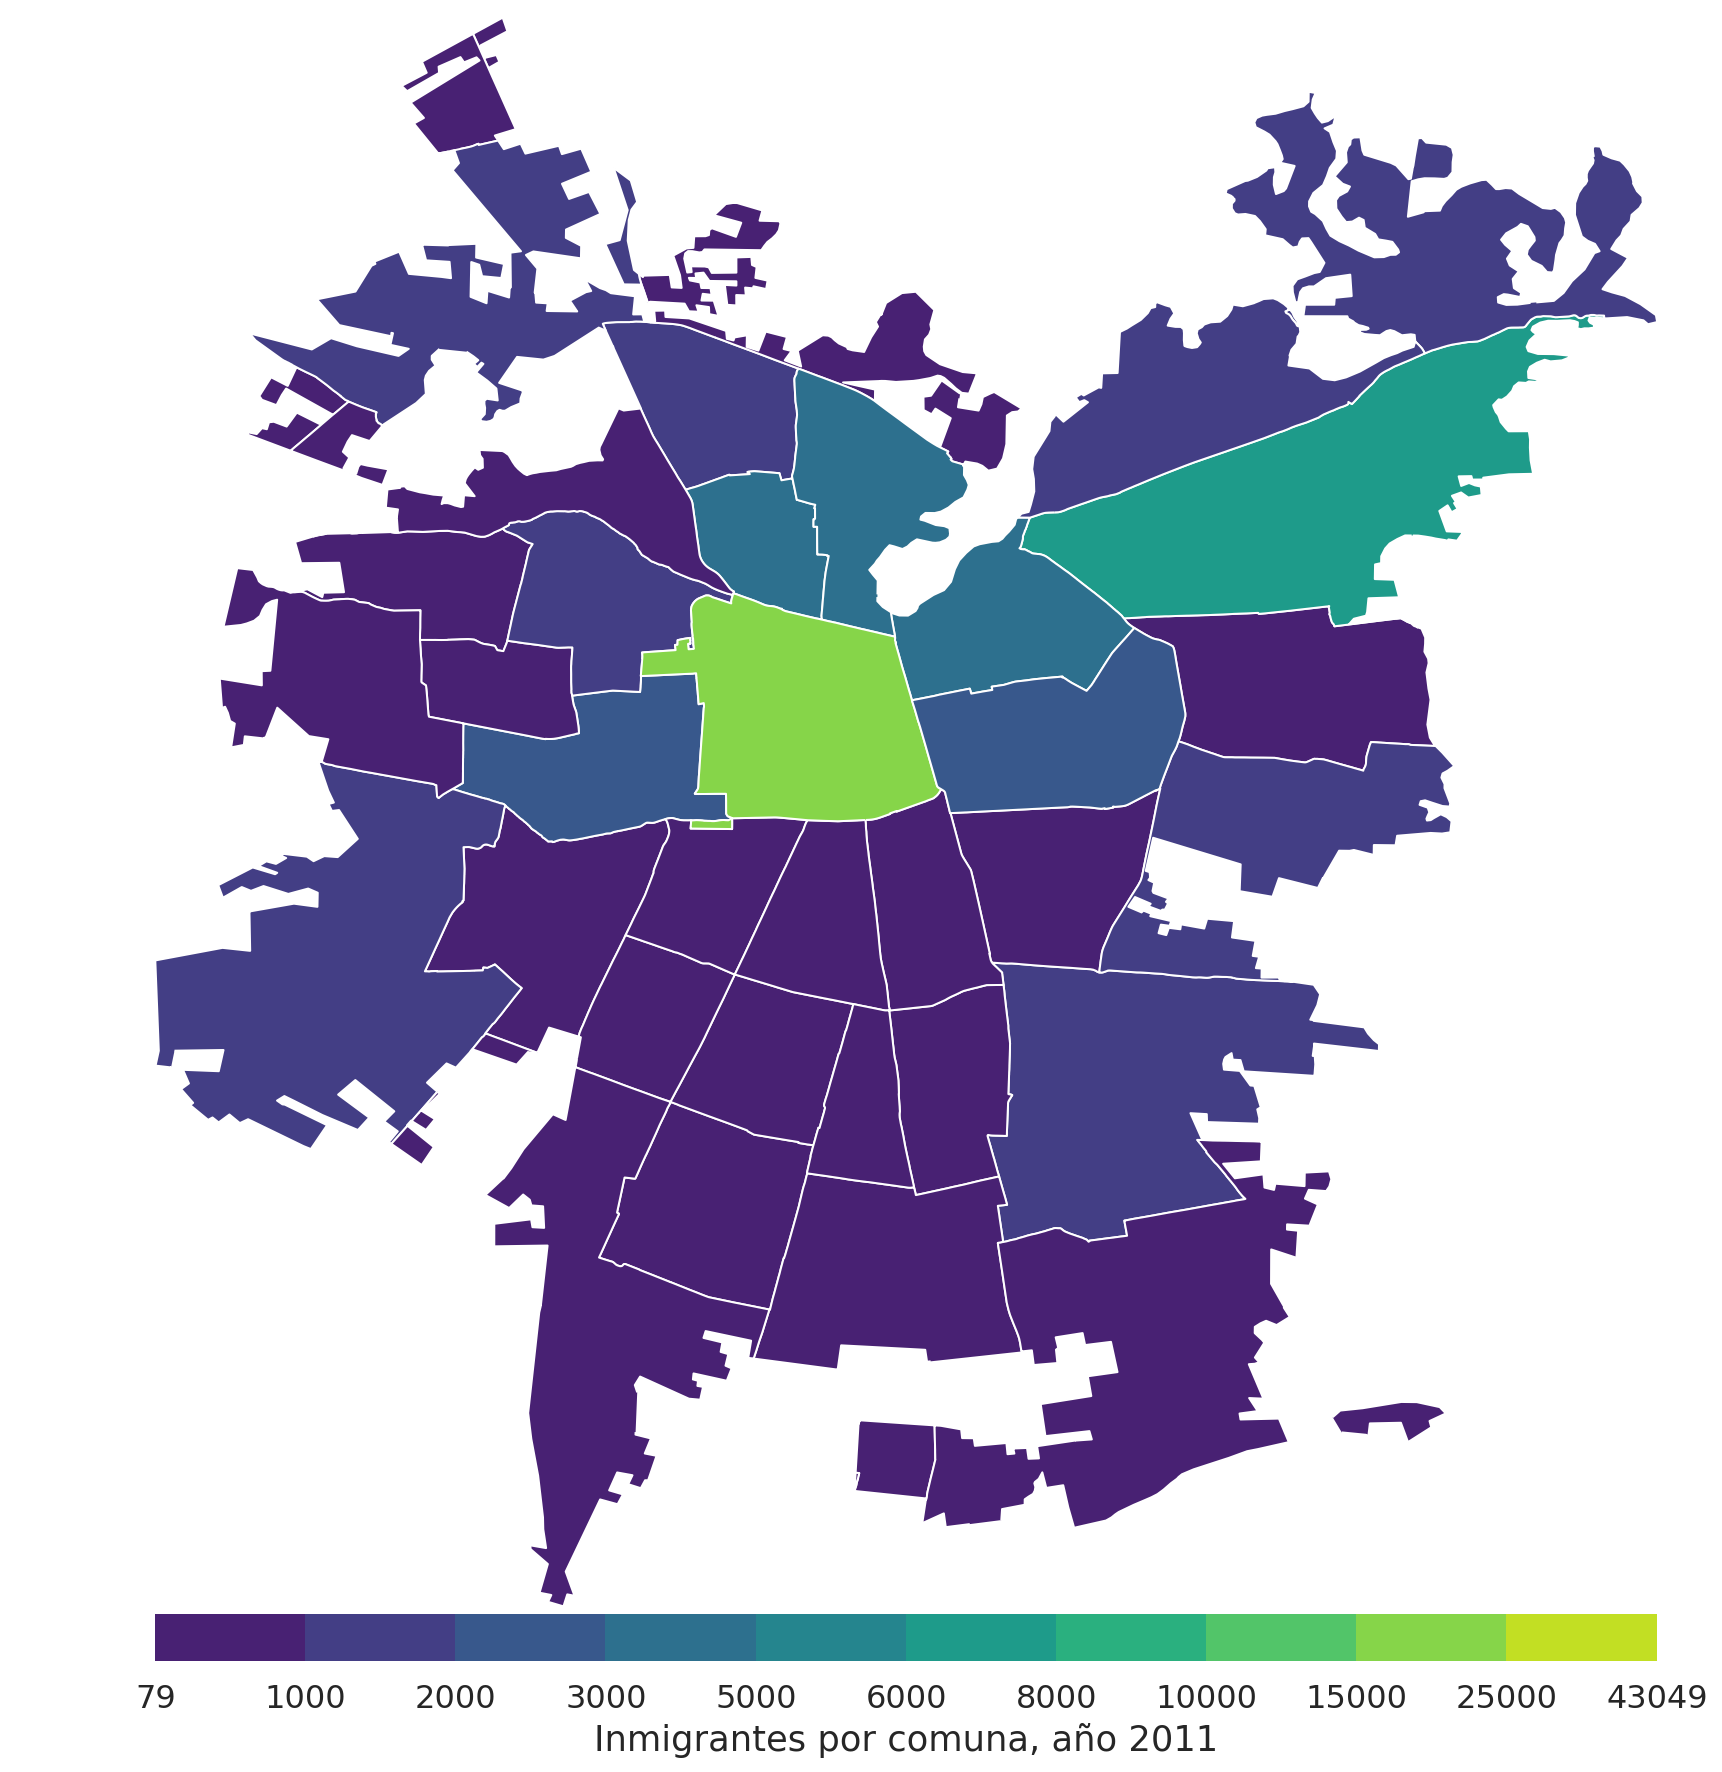

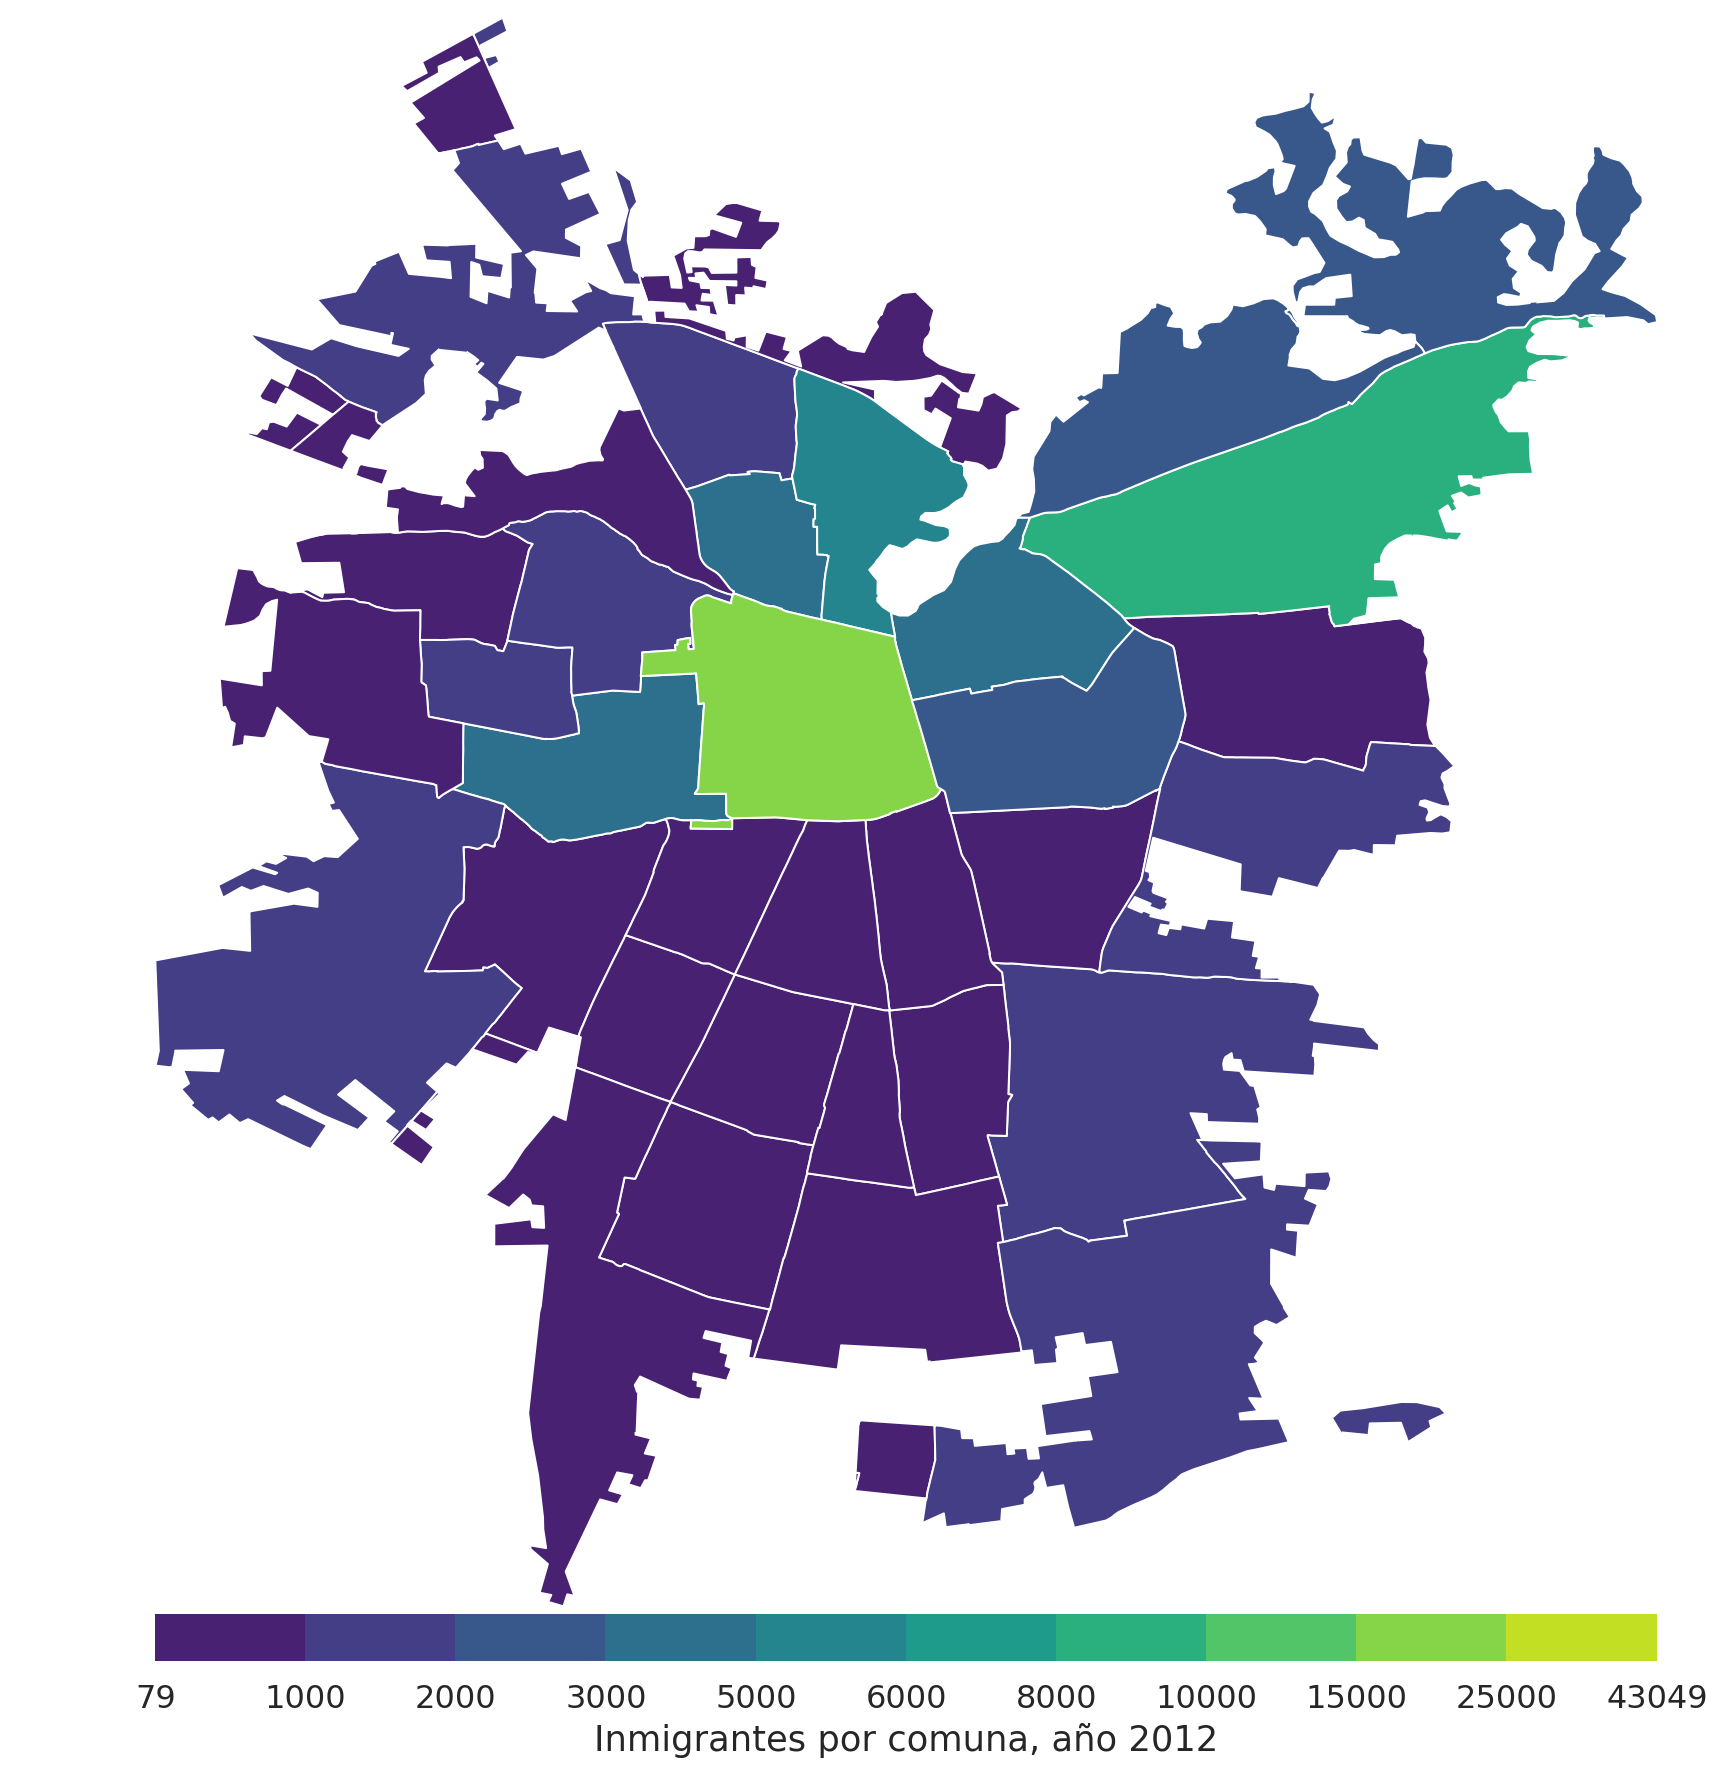

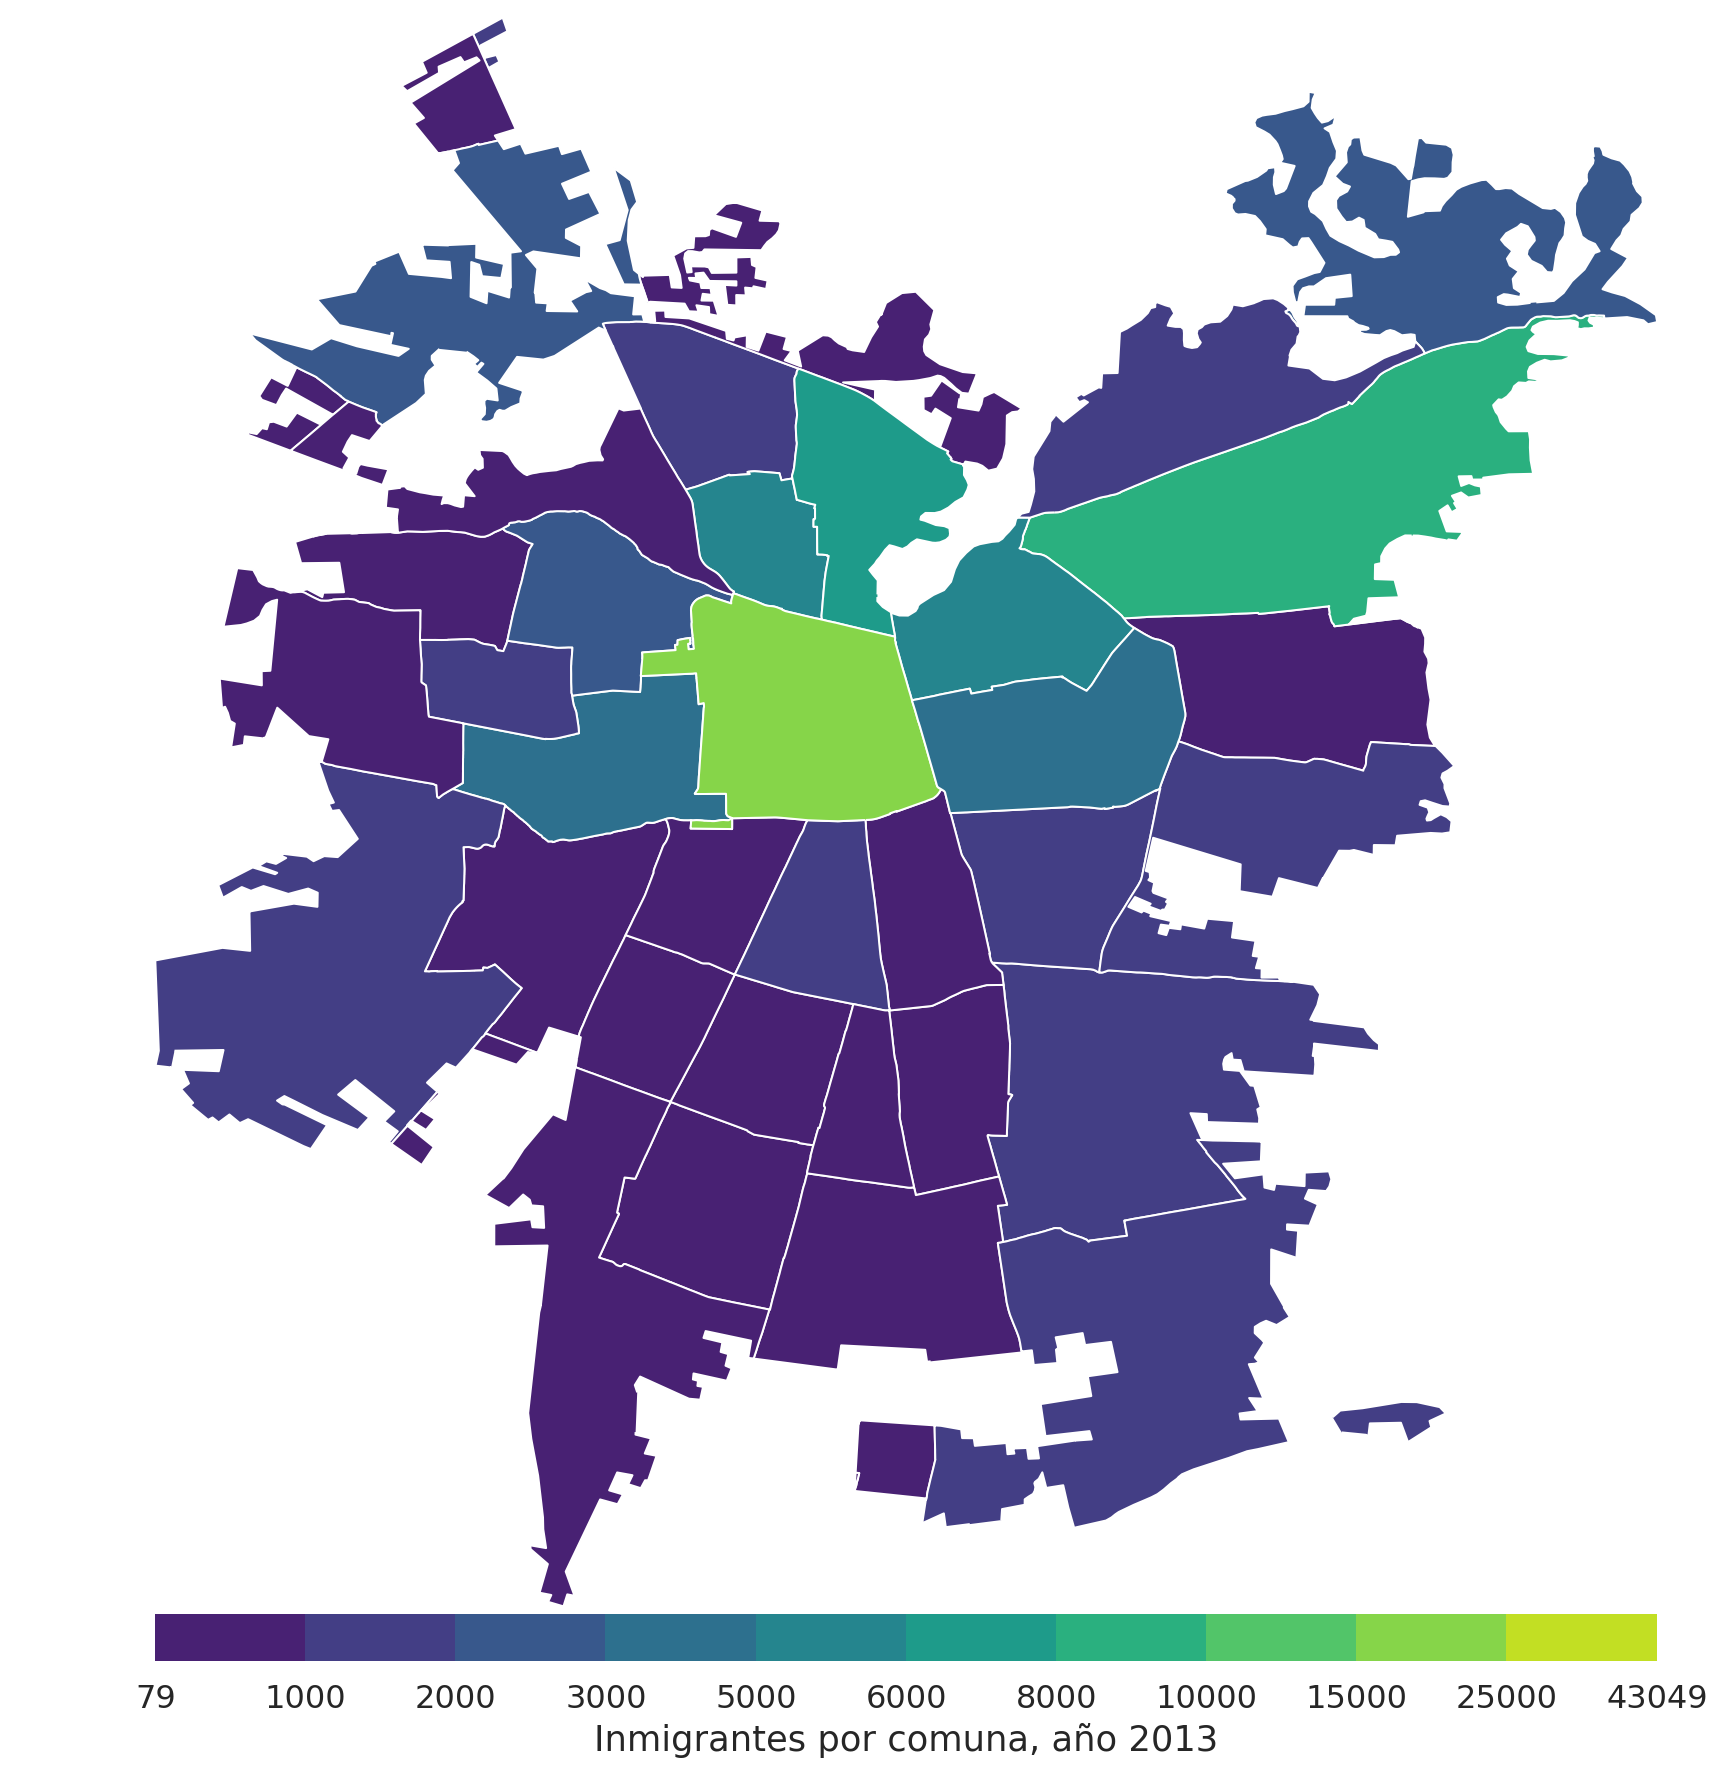

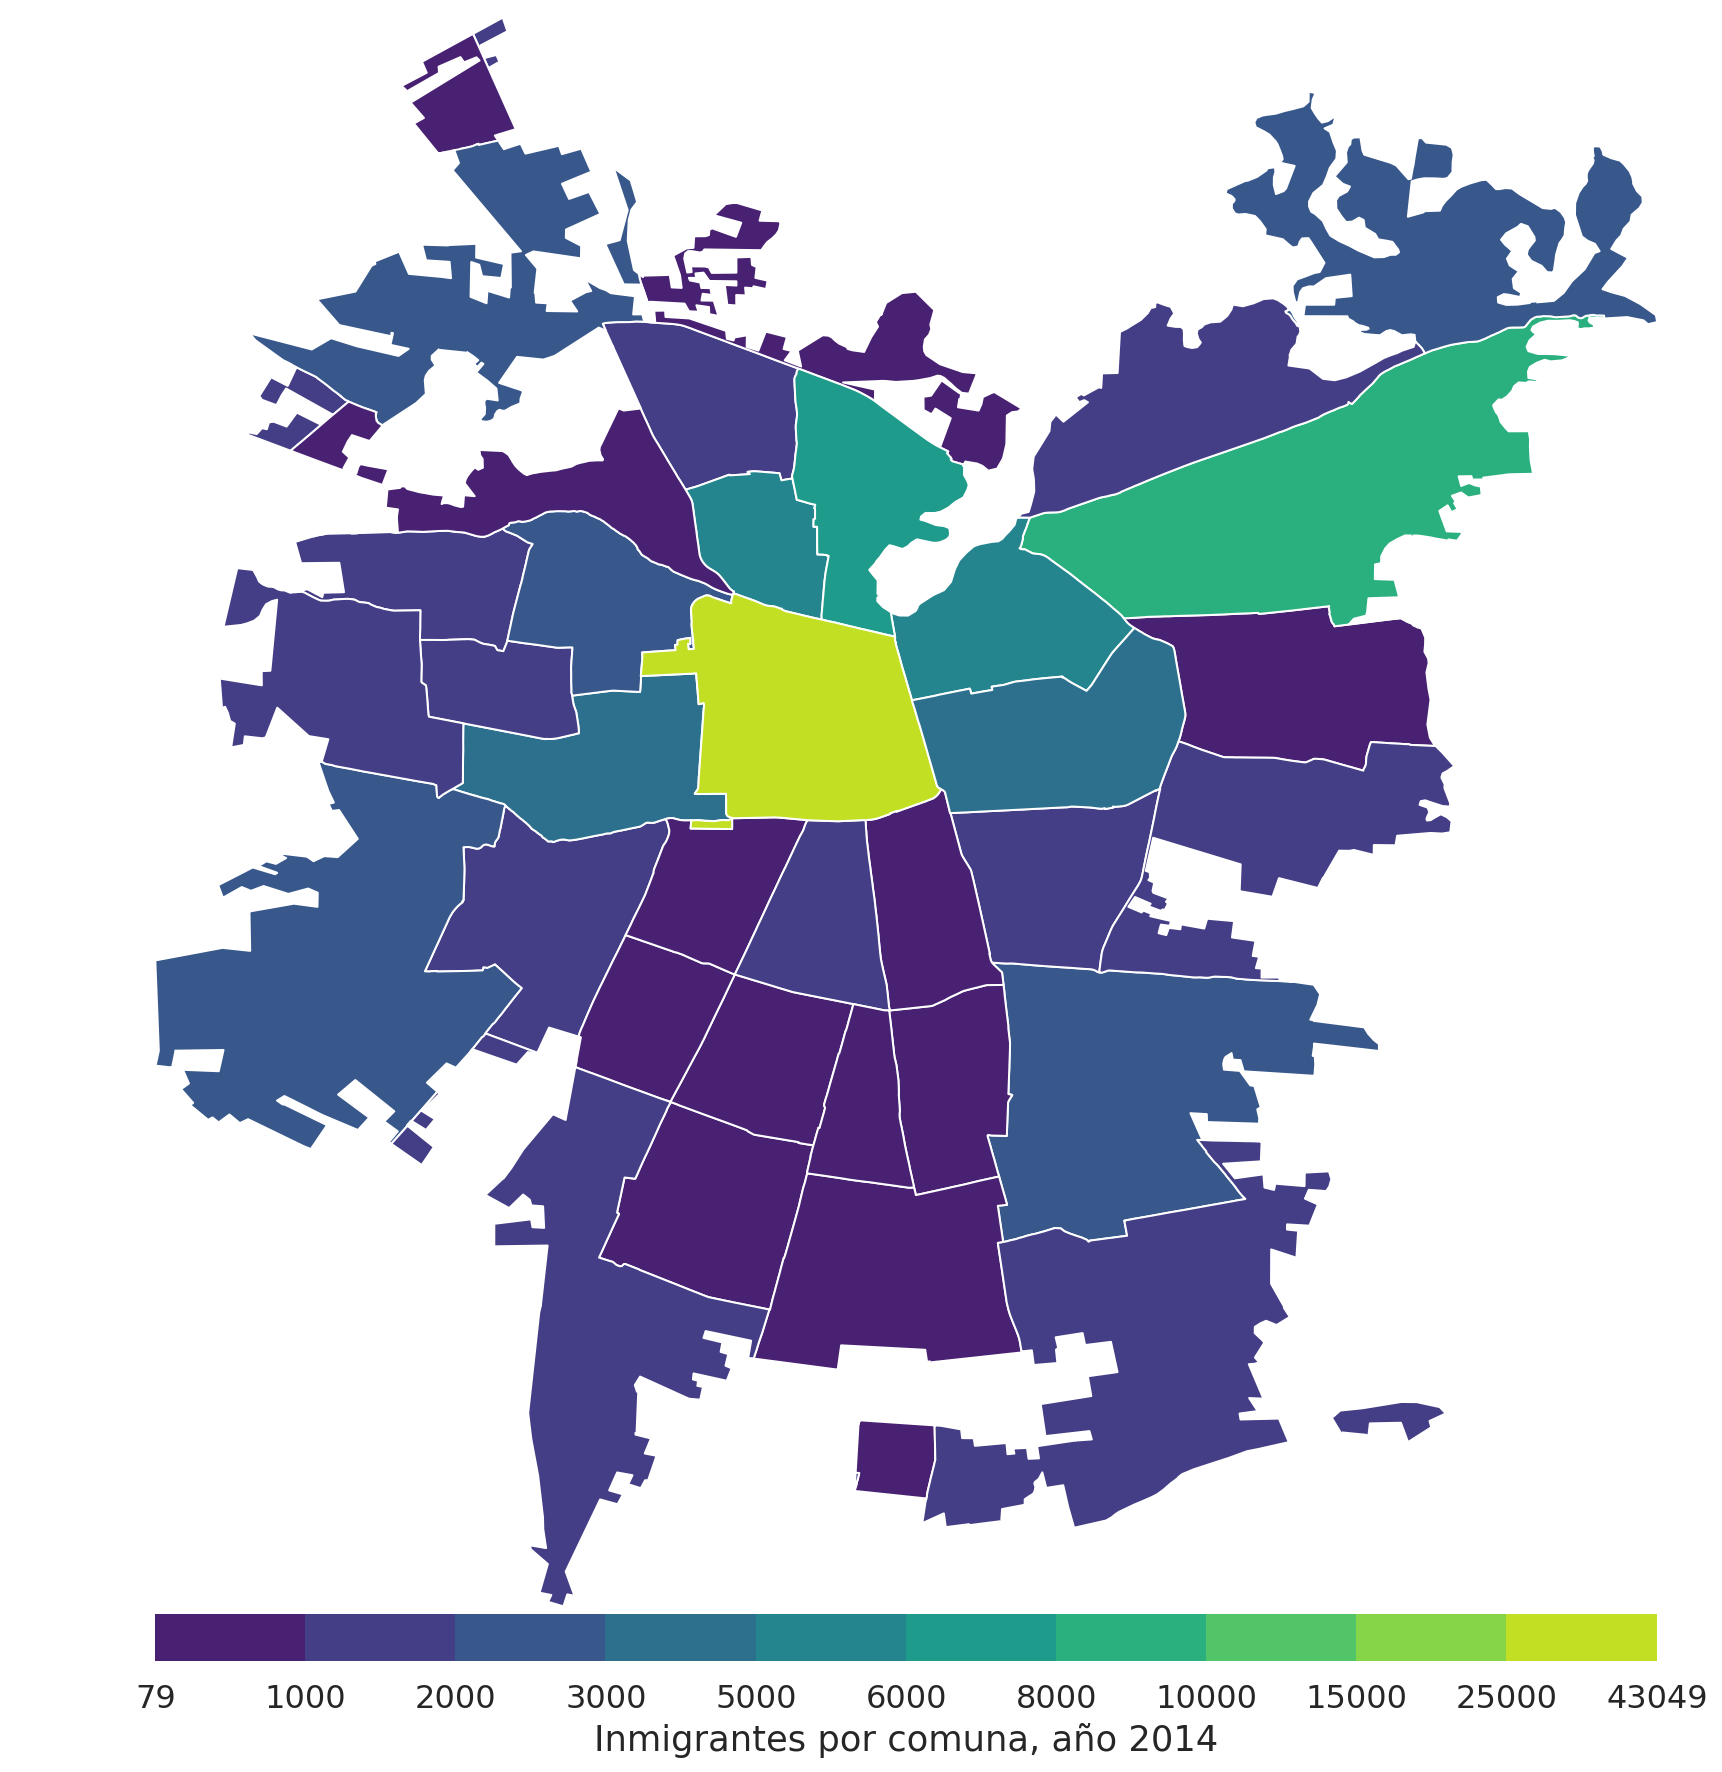

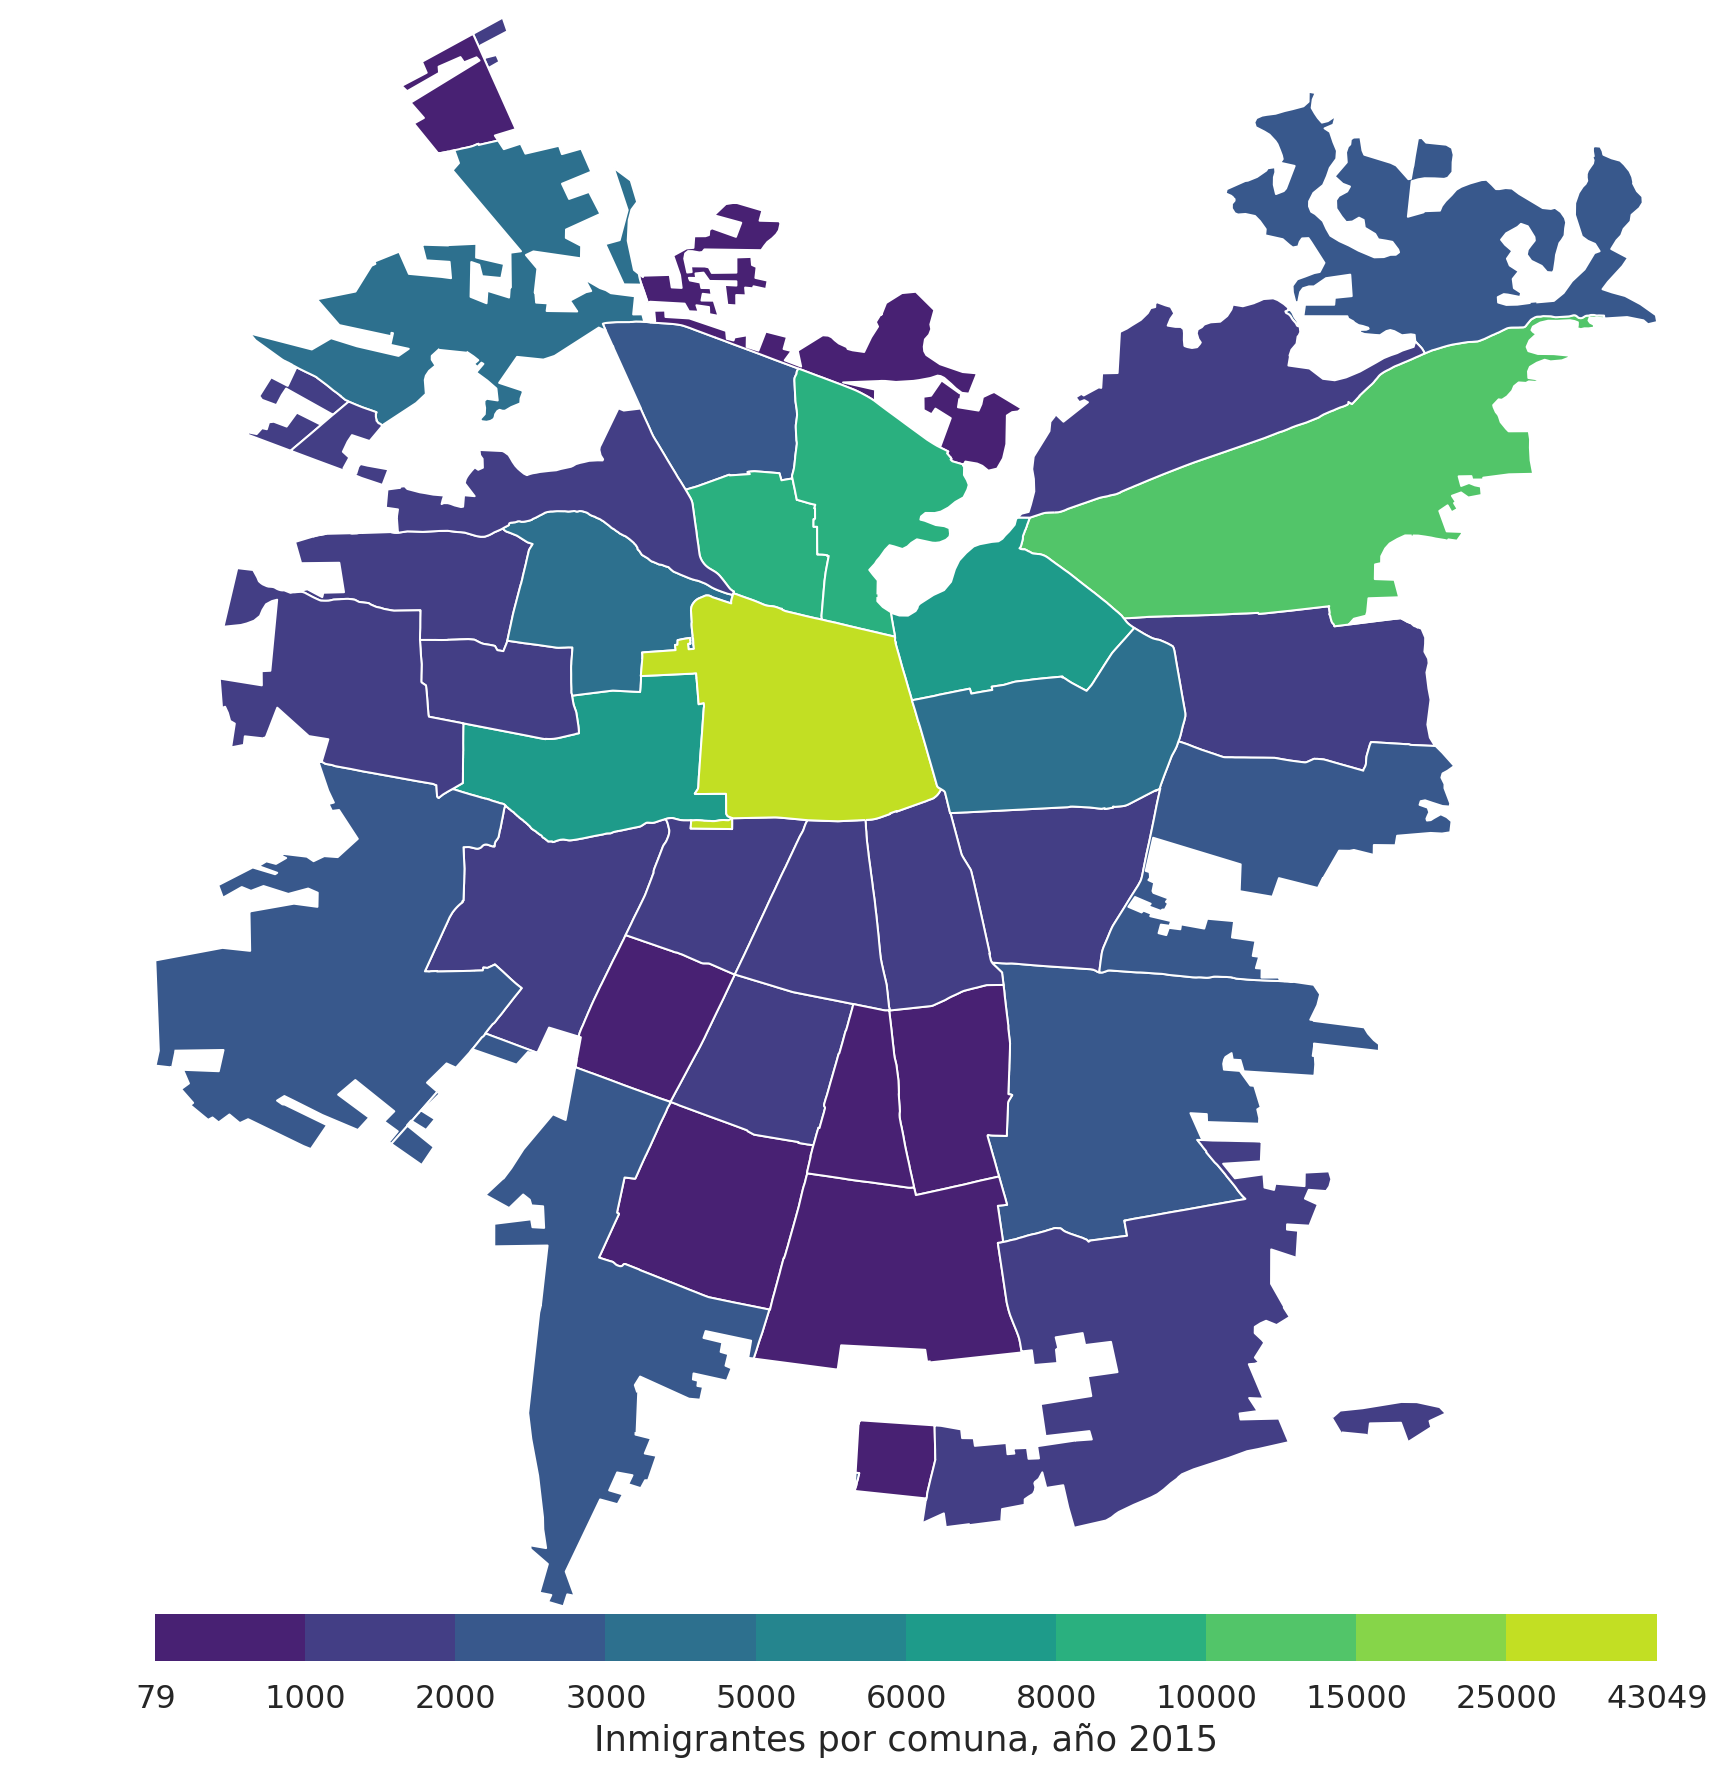

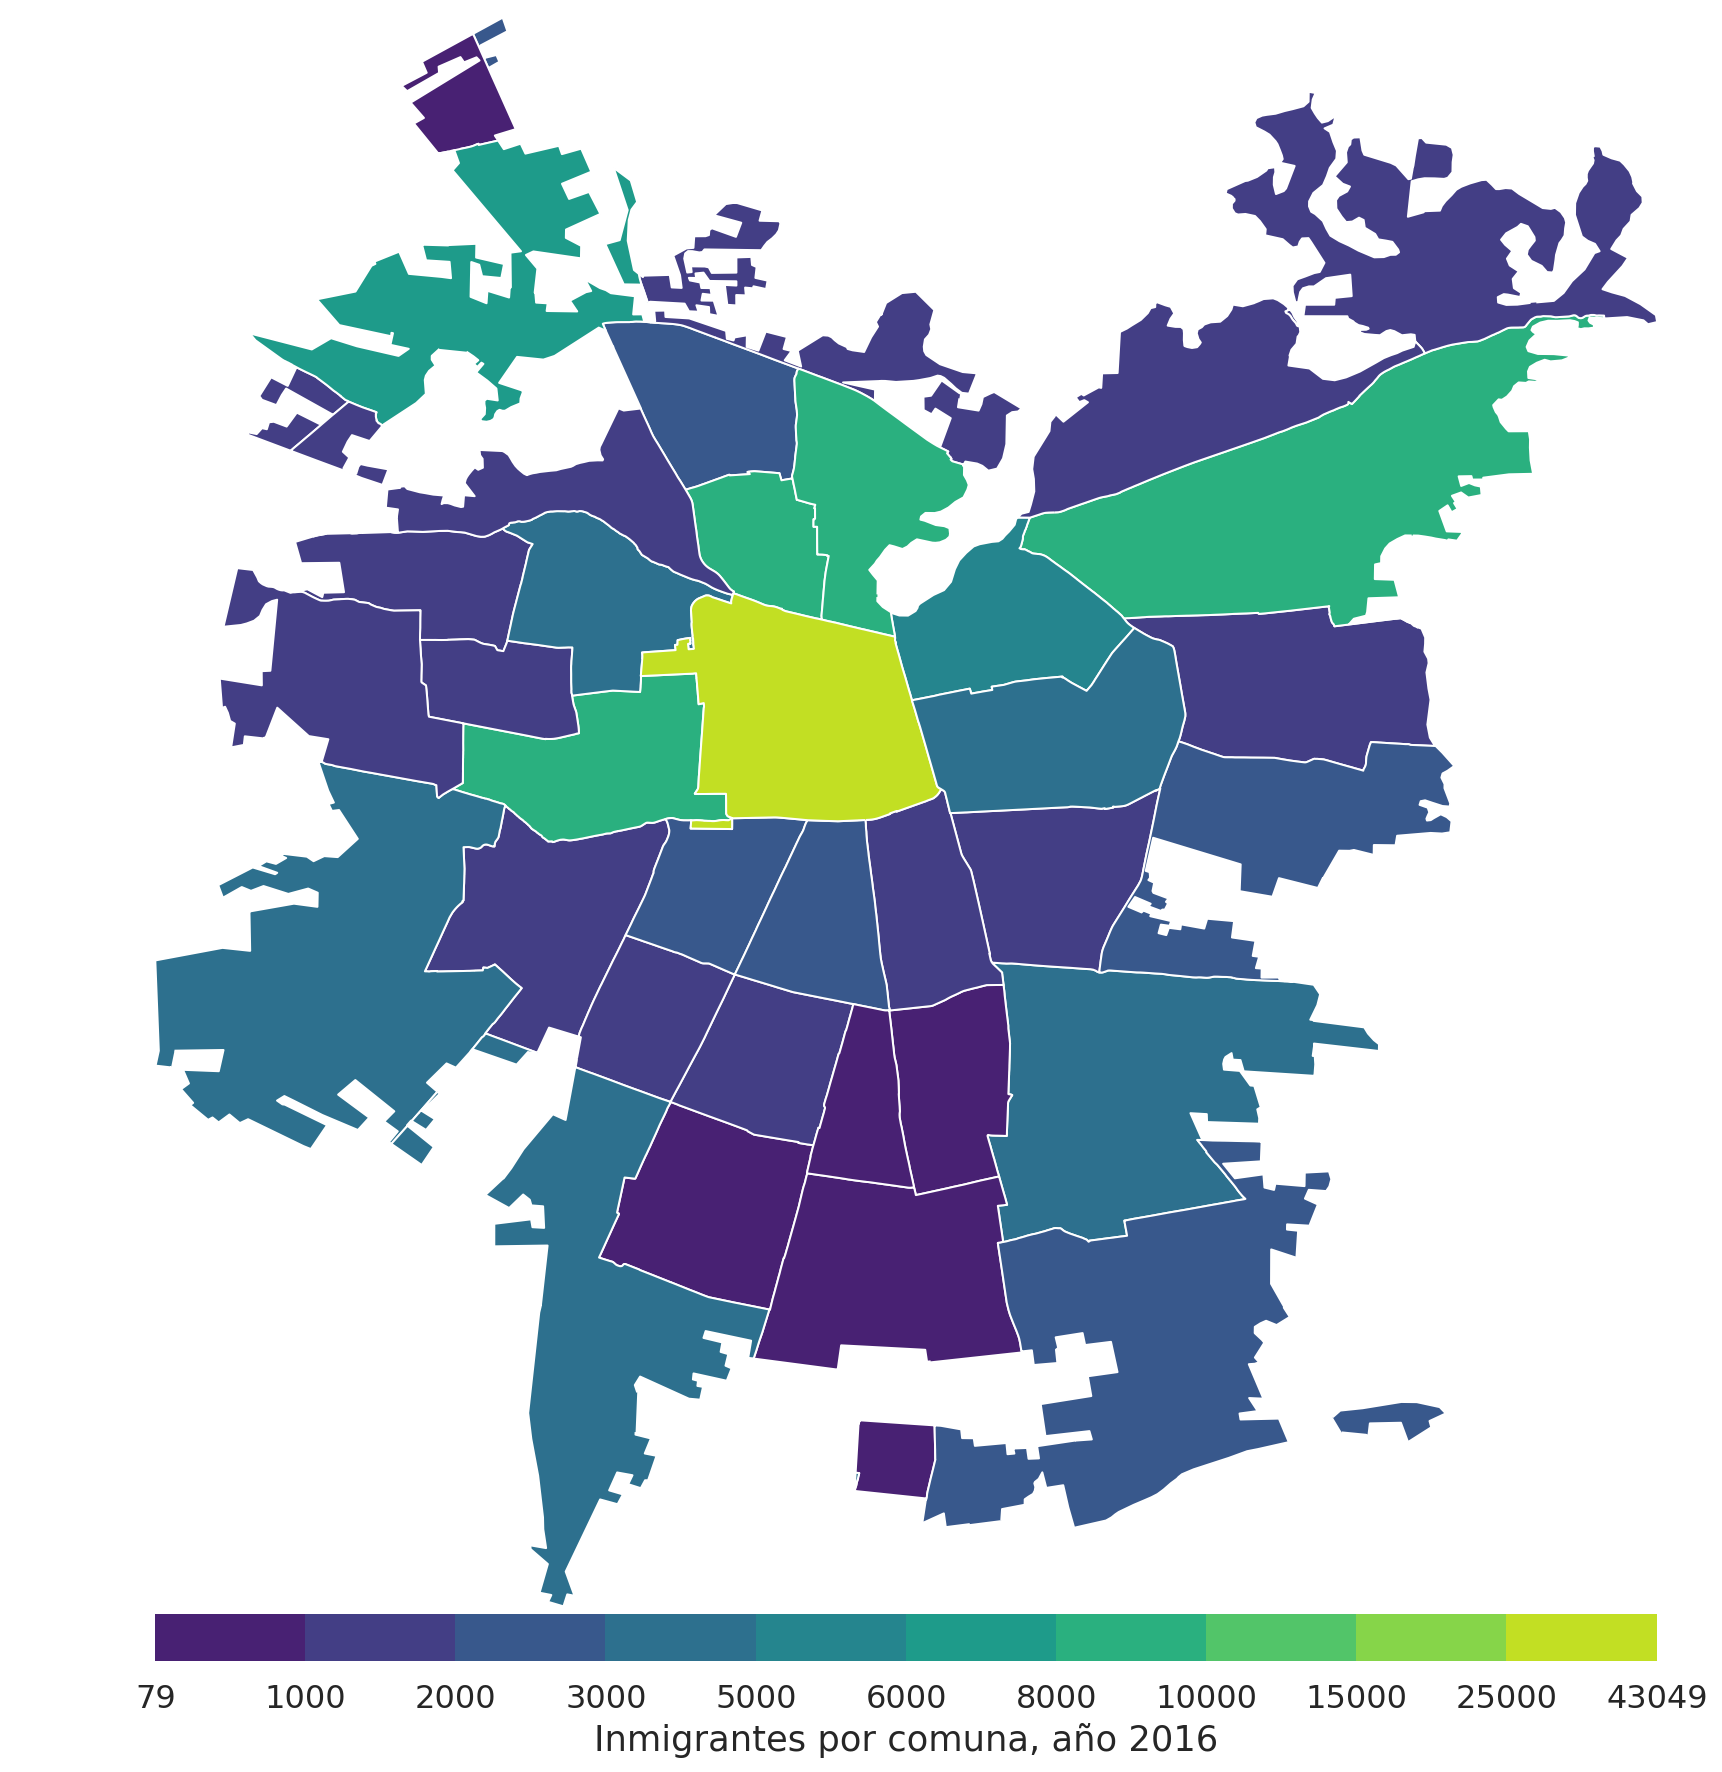

In [32]:
datos_mapa = comunas_santiago.merge(poblacion_comuna,how='inner')
file_name = 'migrants_{}.png'
years = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
for year in years:
  datos_mapa_by_year = datos_mapa[datos_mapa['Year'] == year]
  choropleth(datos_mapa_by_year, column='counts', alpha=1.0, cbar_orientation='horizontal', cbar_label='Inmigrantes por comuna, año {}'.format(year),scheme='user_defined', user_bins=[79,   1000, 2000,  3000, 5000,  6000, 8000,  10000, 15000, 25000, 43049], n_colors=10)
  plt.savefig(file_name.format(year), dpi=150, bbox_inches='tight')



### Descarga de mapas

In [0]:
from google.colab import files
for year in years:
  files.download(file_name.format(year))